# Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
import gc
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from utils import *

2023-04-15 12:57:55.871213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data

In [2]:
df = pd.read_csv('data/taxi_pickups_area.csv', index_col='Trip Start Timestamp', parse_dates=True)
df.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-04-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-04-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2019-04-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2019-04-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-04-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8064 entries, 2019-04-01 00:00:00 to 2019-06-23 23:45:00
Columns: 78 entries, Pickup Community Area_0 to Pickup Community Area_77
dtypes: float64(78)
memory usage: 4.9 MB


In [4]:
df_train = df[:'2019-06-16'].copy()
df_train.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-16 22:45:00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
2019-06-16 23:00:00,4.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2019-06-16 23:15:00,4.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1.0
2019-06-16 23:30:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
2019-06-16 23:45:00,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0


In [5]:
df_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7392 entries, 2019-04-01 00:00:00 to 2019-06-16 23:45:00
Columns: 78 entries, Pickup Community Area_0 to Pickup Community Area_77
dtypes: float64(78)
memory usage: 4.5 MB


In [6]:
df_val = df['2019-06-17':'2019-06-23'].copy()
df_val.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 22:45:00,4.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
2019-06-23 23:00:00,3.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
2019-06-23 23:15:00,3.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0
2019-06-23 23:30:00,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0
2019-06-23 23:45:00,5.0,2.0,0.0,0.0,0.0,0.0,3.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0


In [7]:
df_val.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2019-06-17 00:00:00 to 2019-06-23 23:45:00
Columns: 78 entries, Pickup Community Area_0 to Pickup Community Area_77
dtypes: float64(78)
memory usage: 414.8 KB


# Task
In this project, you will work on demand forecasting. This task might be useful for many different industries: manufacturers, retailers, banks, etc. This time you will help a taxi company optimize their business. If you can predict that in certain areas tomorrow X taxis will be needed at that time, you can reduce arrival time and be better than the competitors. In order to do this you will need to try different architectures:

В этом проекте вы будете работать над прогнозированием спроса. Эта задача может быть полезна для самых разных отраслей: производителей, ритейлеров, банков и т. д. На этот раз вы поможете таксопарку оптимизировать их бизнес. Если вы можете предсказать, что завтра в определенных районах в это время потребуется X такси, вы можете сократить время прибытия и быть лучше конкурентов. Для этого вам нужно будет попробовать разные архитектуры:

## Naive averages
1. For each area make a prediction with the global average for this area for the next 673 intervals.
2. Calculate mean absolute error (MAE) for your own validation dataset.
---
1. Для каждой области сделайте прогноз с глобальным средним значением для этой области на следующие 673 интервала.
2. Рассчитайте среднюю абсолютную ошибку (MAE) для собственного набора проверочных данных.

Посчитаем глобальные средние значения по каждой области (т.е. столбцу) датафрейма df. Это будут предсказания на следующую неделю

In [8]:
df_naive_average_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_naive_average_predict.fillna(0.0, inplace=True)
df_naive_average_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-30 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
for area in df:
	df_naive_average_predict[area] = df[area].mean()

df_naive_average_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-24 00:00:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-24 00:15:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-24 00:30:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-24 00:45:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-24 01:00:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249


Посчитаем MAE для валидационного датафрейма df_val. Сначала, аналогично тому, как делали выше, определим значения для df_val_predict, вычисляя глобальное среднее для каждой области (столбцу) датафрейма df_train

In [10]:
df_val_predict = df_val.copy() * 0.0
df_val_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
for area in df:
	df_val_predict[area] = df_train[area].mean()

df_val_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-17 00:00:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297
2019-06-17 00:15:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297
2019-06-17 00:30:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297
2019-06-17 00:45:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297
2019-06-17 01:00:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297


In [12]:
df_total = df.copy()
df_total = df_total.append(df_naive_average_predict)
df_total.tail(700)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_1680/1148898842.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_naive_average_predict)


,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 17:00:00,7.00000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,20.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000
2019-06-23 17:15:00,1.00000,2.00000,1.000000,1.000000,1.000000,0.000000,9.000000,2.000000,14.00000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000
2019-06-23 17:30:00,6.00000,0.00000,0.000000,0.000000,0.000000,0.000000,6.000000,2.000000,13.00000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000
2019-06-23 17:45:00,6.00000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,2.000000,19.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,1.000000
2019-06-23 18:00:00,10.00000,1.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,23.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30 22:45:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-30 23:00:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-30 23:15:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249


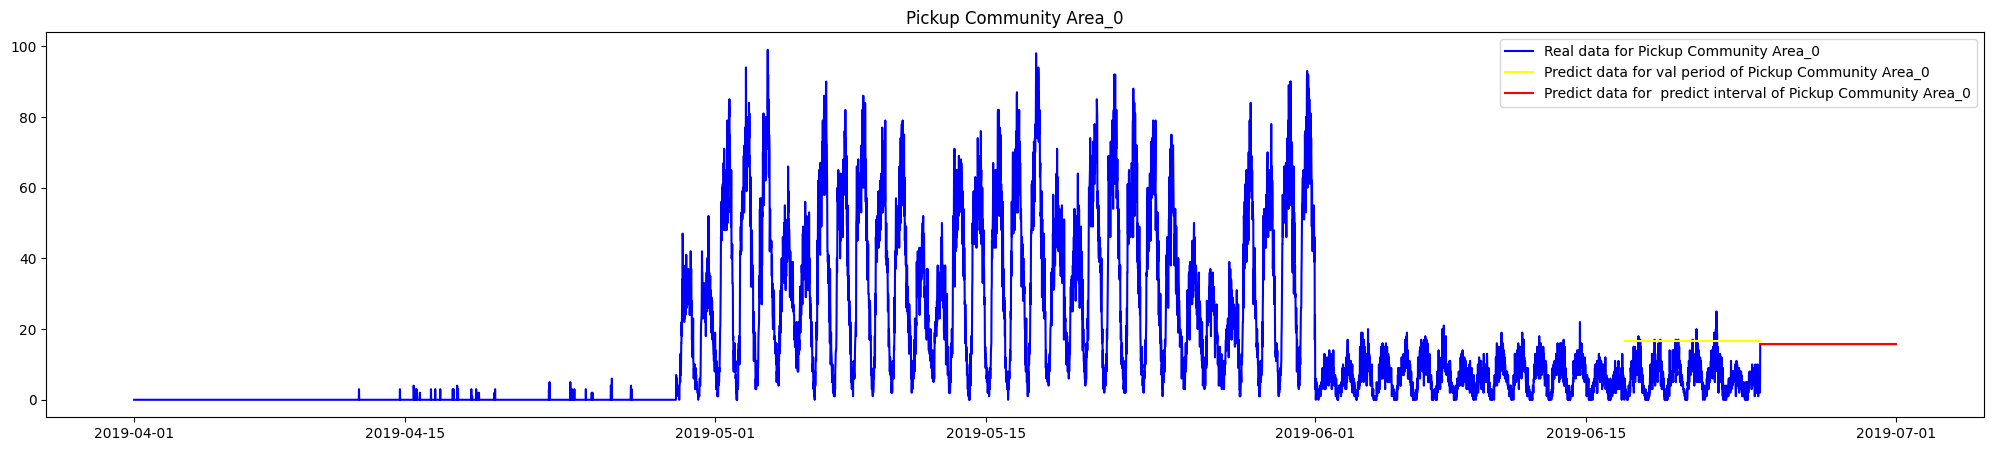

In [13]:
for area in df_total[df_total.columns[:1]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_naive_average_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

In [14]:
df_naive_average_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-30 22:45:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-30 23:00:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-30 23:15:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-30 23:30:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-30 23:45:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249


In [15]:
res_mae = mae_for_df(df_val, df_val_predict)
res_mae

3.1034759511322014

In [16]:
res_mae_ = mean_absolute_error(df_val, df_val_predict)
res_mae_

3.1034759511322014

## Moving averages

1. For each area make a prediction with different moving averages for this area for the next 673 intervals.
2. Calculate mean absolute error (MAE) for the validation dataset.
---
1. Для каждой области сделать прогноз с разными скользящими средними для этой области на следующие 673 интервала.
2. Рассчитайте среднюю абсолютную ошибку (MAE) для проверочного набора данных.

https://habr.com/ru/companies/otus/articles/728118/

Посчитаем скользящие средние значения для разных окон, от получаса до месяца ([2, 4, 96, 672, 2880]) по каждой области (т.е. столбцу) датафрейма df. Это будут предсказания на следующую неделю

In [17]:
df_moving_average_2_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
										  parse_dates=True)
df_moving_average_4_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
										  parse_dates=True)
df_moving_average_96_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
										   parse_dates=True)
df_moving_average_672_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
											 parse_dates=True)
df_moving_average_2880_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
											 parse_dates=True)

df_dict = {2: df_moving_average_2_predict,
		   4: df_moving_average_4_predict,
		   96: df_moving_average_96_predict,
		   672: df_moving_average_672_predict,
		   2880: df_moving_average_2880_predict}

In [18]:
for window in [2, 4, 96, 672, 2880]:
	df_dict[window].fillna(0.0, inplace=True)

In [19]:
df_moving_average_4_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-24 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# for area in df:
#     for window in [2, 4, 96, 672, 2880]:
#         df_dict[window][area] = df[area].rolling(window).mean()

for window in [2, 4, 96, 672, 2880]:
	df_dict[window] = df_total.rolling(window, min_periods=1).mean()

In [21]:
df_moving_average_4_predict.head(700)

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-24 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Predict for moving average with window = 2:


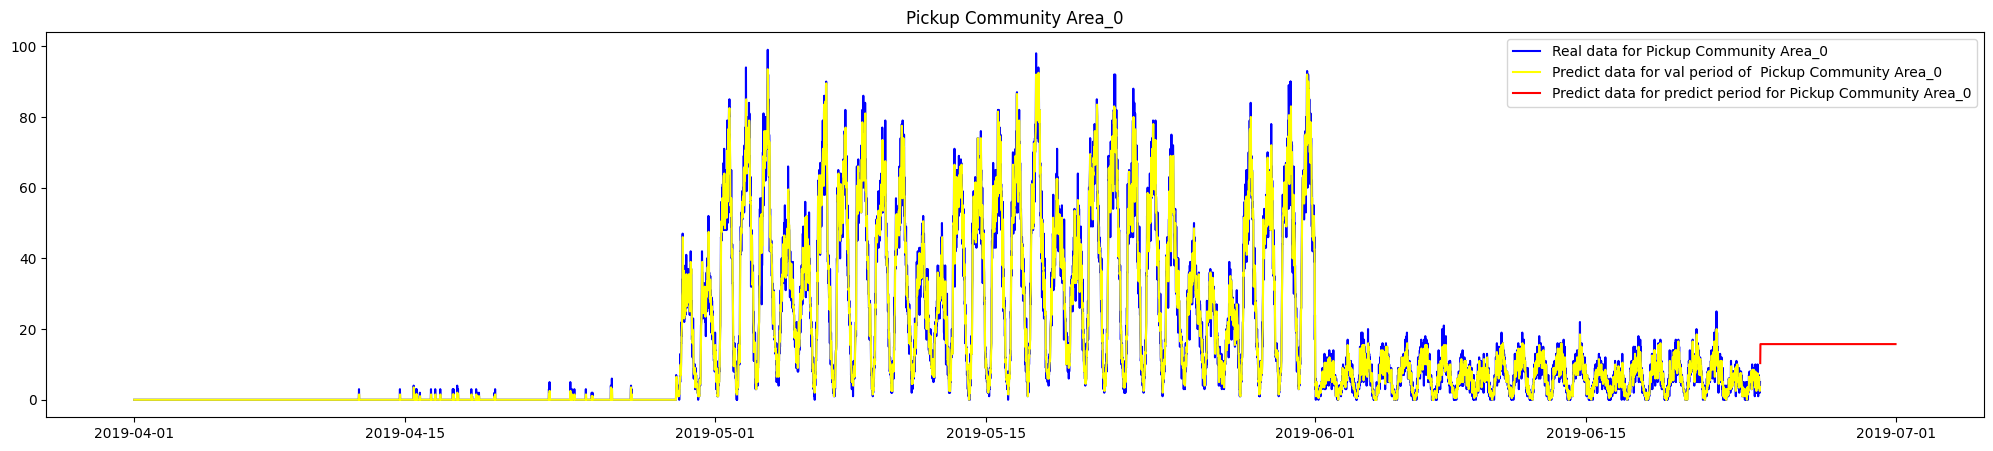

Predict for moving average with window = 4:


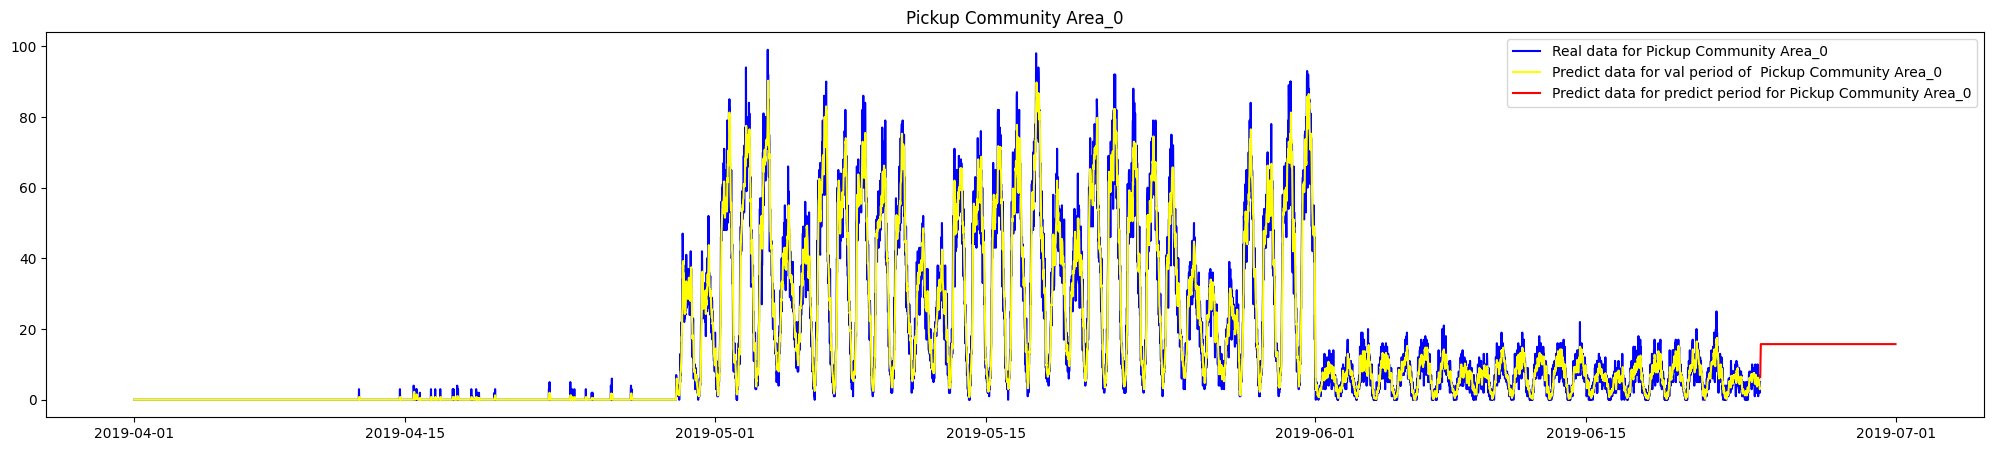

Predict for moving average with window = 96:


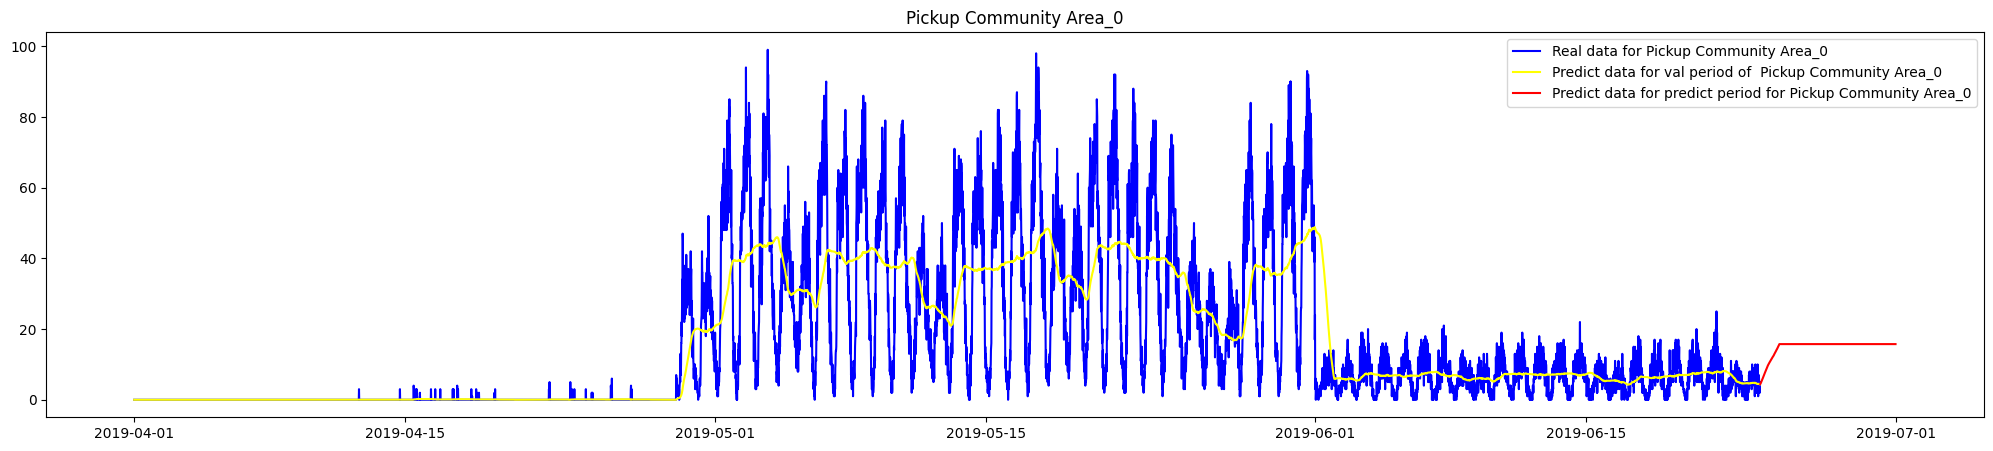

Predict for moving average with window = 672:


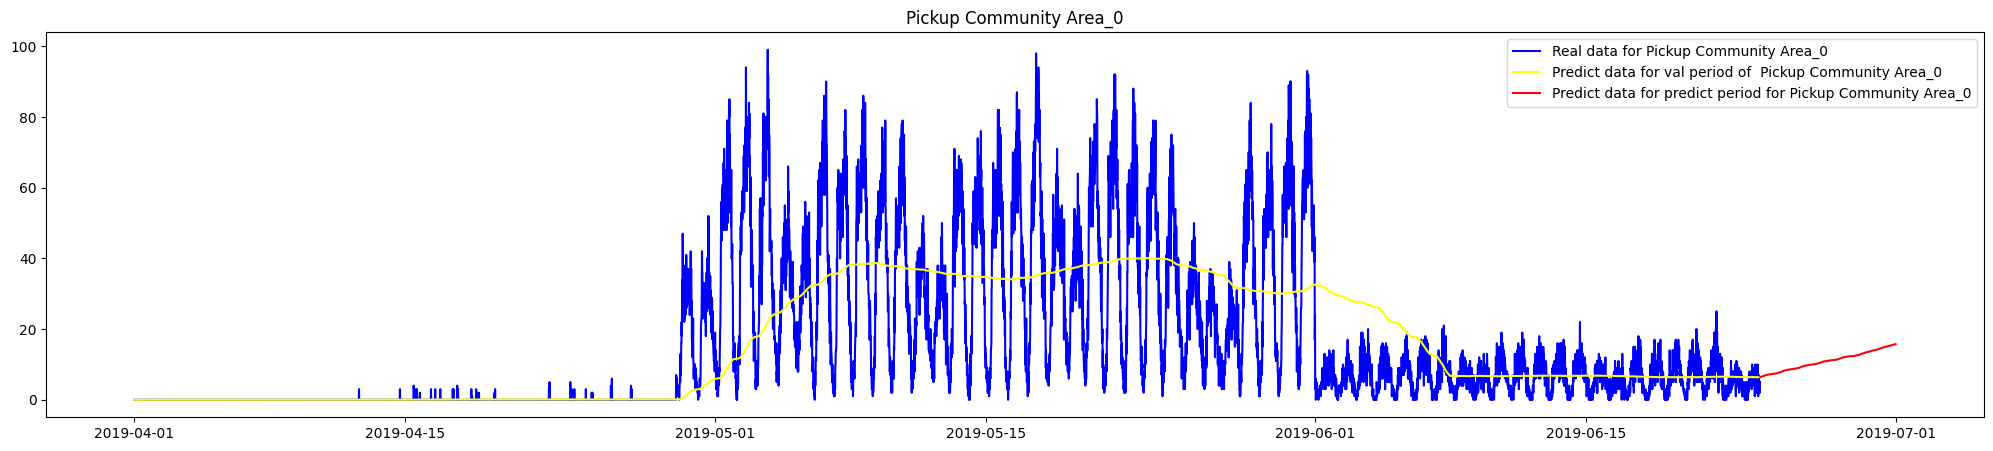

Predict for moving average with window = 2880:


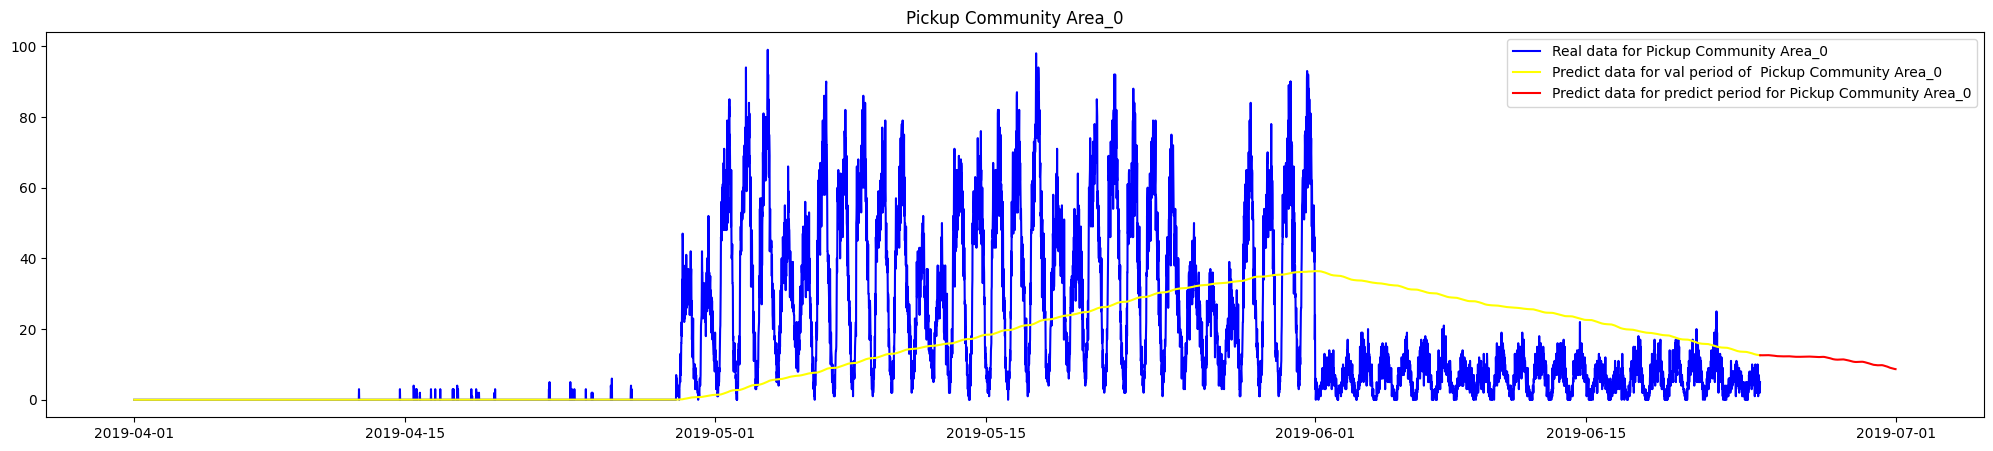

In [22]:
for area in df[df.columns[:1]]:
	for window in [2, 4, 96, 672, 2880]:
		print(f'Predict for moving average with window = {window}:')
		df_val_predict = df.rolling(window, min_periods=1).mean()

		plt.figure(figsize=(25,5))
		plt.plot(df[area], label=f'Real data for {area}', color='blue')
		plt.plot(df_val_predict[area], label=f'Predict data for val period of  {area}', color='yellow')
		plt.plot(df_dict[window][area][-672:], label=f'Predict data for predict period for {area}', color='red')
		plt.legend(loc='best')
		plt.title(area)
		plt.show()

In [23]:
for window in [2, 4, 96, 672, 2880]:
		print(f'MeanAbsoluteError for moving average with window = {window}:')
		df_val_predict = df.rolling(window, min_periods=1).mean()
		print(round(mean_absolute_error(df_val, df_val_predict[-672:]), 2))
		# plt.figure(figsize=(25,5))
		# plt.plot(df[area], label=f'Real data for {area}', color='blue')
		# plt.plot(df_val_predict[area][-672:], label=f'Predict data for val period of  {area}', color='yellow')
		# plt.plot(df_dict[window][area][-672:], label=f'Predict data for predict period for {area}', color='red')

MeanAbsoluteError for moving average with window = 2:
0.2
MeanAbsoluteError for moving average with window = 4:
0.27
MeanAbsoluteError for moving average with window = 96:
0.63
MeanAbsoluteError for moving average with window = 672:
0.65
MeanAbsoluteError for moving average with window = 2880:
1.95


## Exponential smoothing

1. For each area make a prediction with 3 different exponential smoothing algorithms for this area for the next 673 intervals. Optimize the weights.
2. Calculate mean absolute error (MAE) for the validation dataset.


1. Для каждой области сделать прогноз с помощью 3 различных алгоритмов экспоненциального сглаживания для этой области на следующие 673 интервала. Оптимизируйте веса.
2. Рассчитайте среднюю абсолютную ошибку (MAE) для проверочного набора данных.

Разложим временной ряд и посмотрим, есть ли в данных уровни, тренды и сезонность. Период - 15 минут (4*24).

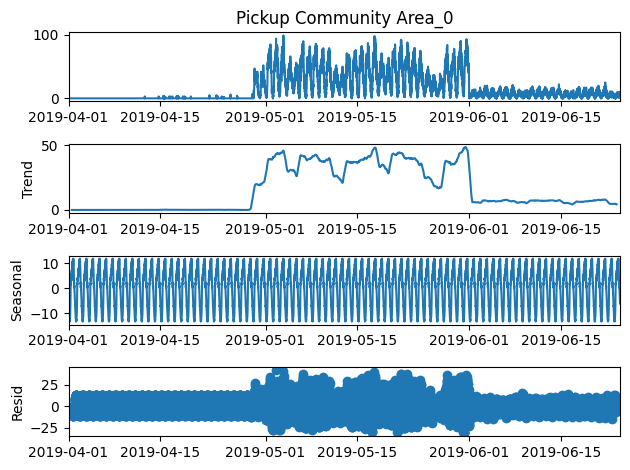

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

for area in df_total[df_total.columns[:1]]:
	decompose_result = seasonal_decompose(df[area], period = 4*24, model='additive')
	decompose_result.plot()

In [25]:
df_val = df['2019-06-17':'2019-06-23'].copy()
df_val_predict = df_val.copy() * 0.0
# df_val = df.copy()
# df_val_predict = df_val.copy() * 0.0
for area in df_train:
	model = SimpleExpSmoothing(np.asarray(df_train[area])).fit(smoothing_level=0.2, optimized=False, use_brute=True)
	# df_val_predict[area] = model.fittedvalues[:672]
	df_val_predict[area] = model.forecast(672)

In [26]:
df_braun_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_braun_predict.fillna(0.0, inplace=True)

for area in df_train:
	model = SimpleExpSmoothing(np.asarray(df[area])).fit(smoothing_level=0.2, optimized=False, use_brute=True)
	df_braun_predict[area] = model.forecast(672)
	# df_braun_predict[area] = model.fittedvalues[:672]

In [27]:
df_total = df.copy()
df_total = df_total.append(df_braun_predict)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_1680/4151968948.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_braun_predict)


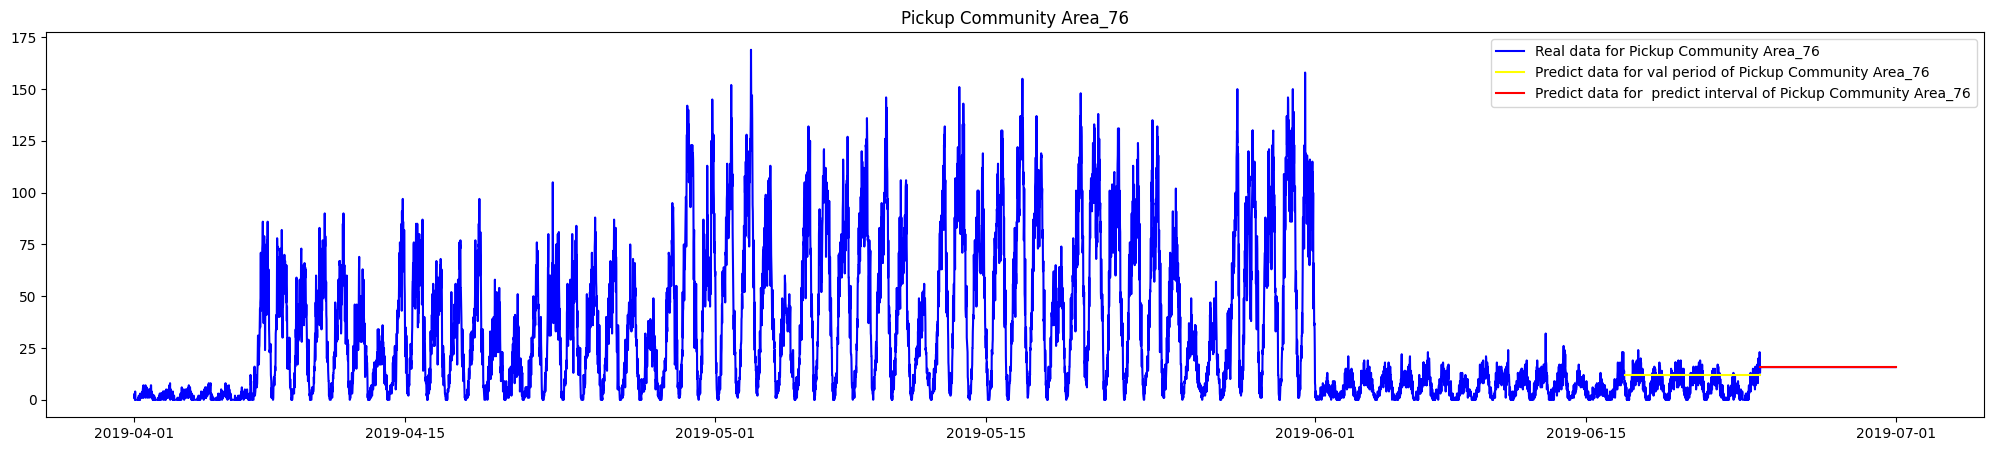

In [28]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_braun_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

In [29]:
# df_val = df.copy()
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

0.7544415490714245

In [30]:
df_val_predict = df_val.copy() * 0.0
for area in df_train:
	model = Holt(np.asarray(df_train[area])).fit(smoothing_level=0.2, smoothing_trend=0.00045, optimized=False, use_brute=True)
	df_val_predict[area] = model.forecast(672)
	# df_val_predict[area] = model.fittedvalues[:672]

In [31]:
df_holt_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_holt_predict.fillna(0.0, inplace=True)

for area in df_train:
	model = Holt(np.asarray(df[area])).fit(smoothing_level=0.2, smoothing_trend=0.00045, optimized=False, use_brute=True)
	df_holt_predict[area] = model.forecast(672)
	# df_holt_predict[area] = model.fittedvalues[:672]

In [32]:
df_total = df.copy()
df_total = df_total.append(df_holt_predict)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_1680/2067574991.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_holt_predict)


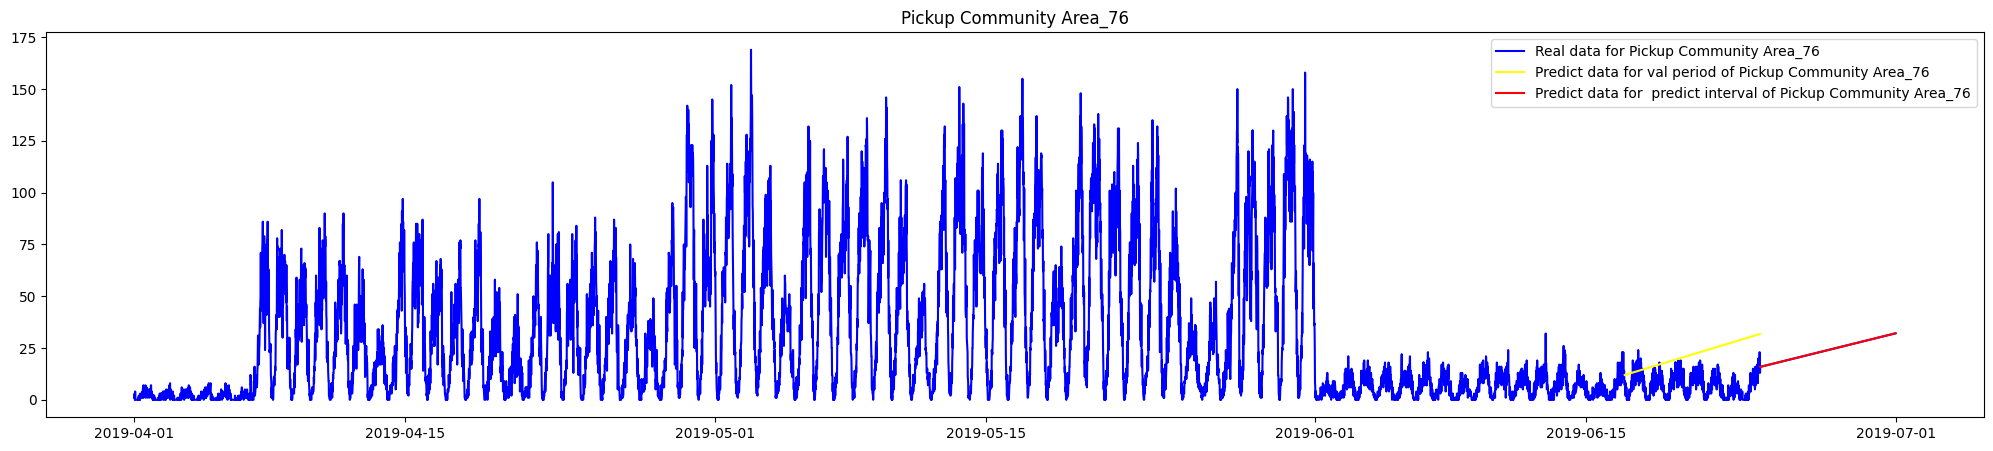

In [33]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_holt_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

In [34]:
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

0.9164567842547973

In [35]:
df_holt_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-24 00:00:00,4.065681,0.414302,0.250088,0.362041,-0.000608,0.078666,2.863544,0.756452,7.986974,-0.000025,...,0.000332,0.069944,-0.000108,0.000483,-0.000039,-0.000051,-0.000015,-0.000097,15.883335,0.102248
2019-06-24 00:15:00,4.061121,0.414146,0.249869,0.361399,-0.000871,0.078525,2.861698,0.755033,7.990633,-0.000030,...,0.000308,0.069939,-0.000129,0.000447,-0.000047,-0.000082,-0.000018,-0.000117,15.907492,0.101657
2019-06-24 00:30:00,4.056562,0.413989,0.249650,0.360757,-0.001135,0.078385,2.859851,0.753613,7.994293,-0.000035,...,0.000284,0.069933,-0.000151,0.000411,-0.000054,-0.000113,-0.000021,-0.000136,15.931649,0.101066
2019-06-24 00:45:00,4.052002,0.413833,0.249432,0.360115,-0.001398,0.078244,2.858005,0.752193,7.997952,-0.000040,...,0.000260,0.069928,-0.000172,0.000375,-0.000062,-0.000144,-0.000024,-0.000156,15.955806,0.100475
2019-06-24 01:00:00,4.047442,0.413676,0.249213,0.359473,-0.001662,0.078103,2.856158,0.750774,8.001611,-0.000045,...,0.000235,0.069922,-0.000194,0.000338,-0.000070,-0.000175,-0.000027,-0.000175,15.979963,0.099884


In [36]:
from scipy.special import lmbda

df_val_predict = df_val.copy() * 0.0
for area in df_train:
	model = ExponentialSmoothing(np.asarray(df_train[area]),
											seasonal_periods=4*24,
											trend="add",
											seasonal="add",
											damped_trend=True,
											use_boxcox=1.01,
											initialization_method="estimated").fit(use_brute=True, smoothing_level=0.2, smoothing_trend=0.00045, smoothing_seasonal=0.35)
	# model = ExponentialSmoothing(np.asarray(df_train[area])).fit()
	df_val_predict[area] = model.forecast(672)

In [37]:
# model.params

In [38]:
df_holt_winters_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_holt_winters_predict.fillna(0.0, inplace=True)

for area in df:
	model = ExponentialSmoothing(np.asarray(df[area]),
											seasonal_periods=4*24,
											trend="add",
											seasonal="add",
											damped_trend=True,
											use_boxcox=1.01,
											initialization_method="estimated").fit(use_brute=True, smoothing_level=0.2, smoothing_trend=0.00045, smoothing_seasonal=0.35)
	df_holt_winters_predict[area] = model.forecast(672)

In [39]:
df_val_predict = df_val_predict.fillna(0)
df_holt_winters_predict = df_holt_winters_predict.fillna(0)

df_total = df.copy()
df_total = df_total.append(df_holt_winters_predict)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_1680/565513785.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_holt_winters_predict)


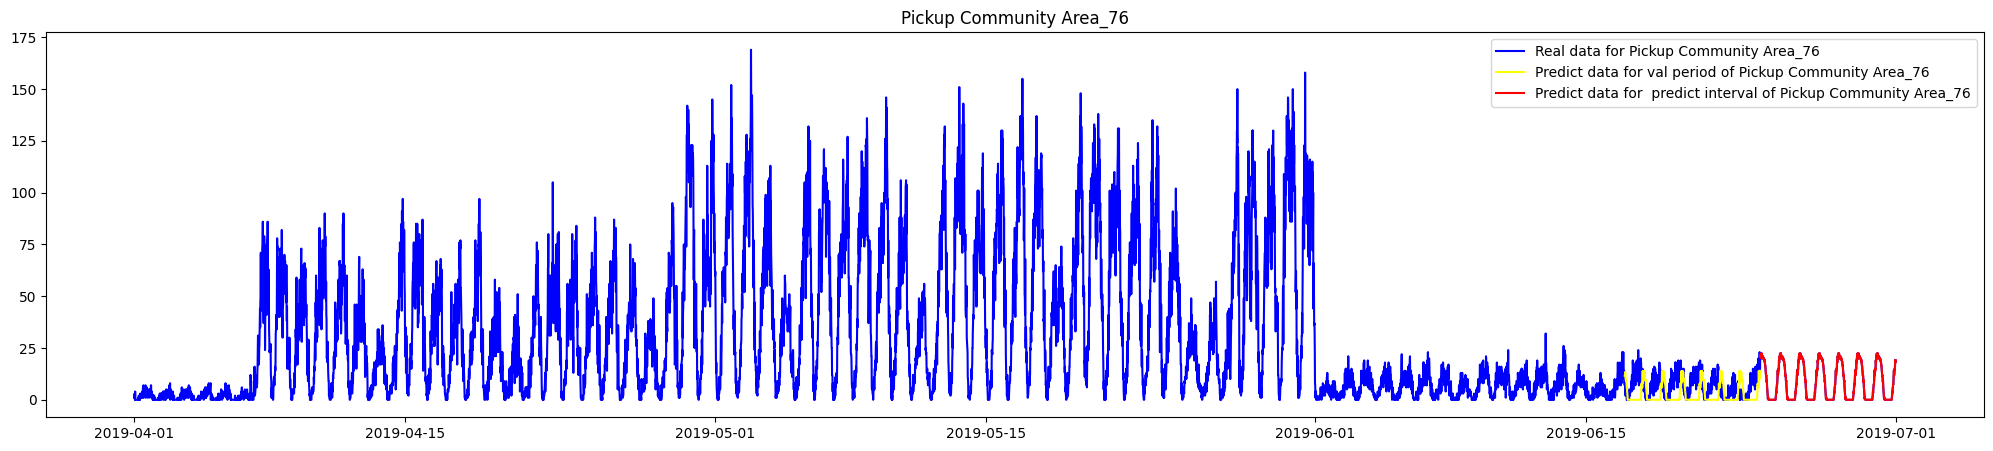

In [40]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_holt_winters_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

In [41]:
df_val_predict = df_val_predict.fillna(0)
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

0.9237520878528087

In [42]:
print(df_holt_winters_predict.head())

                      Pickup Community Area_0  Pickup Community Area_1  \
Trip Start Timestamp                                                     
2019-06-24 00:00:00                  6.451111                 1.166347   
2019-06-24 00:15:00                  6.256079                 0.300252   
2019-06-24 00:30:00                  4.132347                 0.518006   
2019-06-24 00:45:00                  4.415429                 0.074003   
2019-06-24 01:00:00                  1.594332                 0.474762   

                      Pickup Community Area_2  Pickup Community Area_3  \
Trip Start Timestamp                                                     
2019-06-24 00:00:00                  0.430953                 0.000000   
2019-06-24 00:15:00                  0.323437                 0.512152   
2019-06-24 00:30:00                  0.000000                 0.895224   
2019-06-24 00:45:00                  0.080408                 0.000000   
2019-06-24 01:00:00                  

In [43]:
print(df_val.head())


                      Pickup Community Area_0  Pickup Community Area_1  \
Trip Start Timestamp                                                     
2019-06-17 00:00:00                       6.0                      1.0   
2019-06-17 00:15:00                       3.0                      0.0   
2019-06-17 00:30:00                       4.0                      0.0   
2019-06-17 00:45:00                       1.0                      0.0   
2019-06-17 01:00:00                       1.0                      0.0   

                      Pickup Community Area_2  Pickup Community Area_3  \
Trip Start Timestamp                                                     
2019-06-17 00:00:00                       0.0                      0.0   
2019-06-17 00:15:00                       0.0                      1.0   
2019-06-17 00:30:00                       0.0                      1.0   
2019-06-17 00:45:00                       0.0                      0.0   
2019-06-17 01:00:00                  

In [44]:
print(df_val_predict.head())

                      Pickup Community Area_0  Pickup Community Area_1  \
Trip Start Timestamp                                                     
2019-06-17 00:00:00                  2.561086                      0.0   
2019-06-17 00:15:00                  0.000000                      0.0   
2019-06-17 00:30:00                  0.000000                      0.0   
2019-06-17 00:45:00                  0.000000                      0.0   
2019-06-17 01:00:00                  0.000000                      0.0   

                      Pickup Community Area_2  Pickup Community Area_3  \
Trip Start Timestamp                                                     
2019-06-17 00:00:00                       0.0                 0.000000   
2019-06-17 00:15:00                       0.0                 0.308663   
2019-06-17 00:30:00                       0.0                 0.369647   
2019-06-17 00:45:00                       0.0                 0.467567   
2019-06-17 01:00:00                  

## ARIMA

1. For each area make a prediction with the best SARIMA model according to AIC metrics for this area for the next 673 intervals.
2. Calculate mean absolute error (MAE) for the validation dataset.


1. Для каждой области сделать прогноз с помощью лучшей модели SARIMA по метрикам AIC для этой области на следующие 673 интервала.
2. Рассчитайте среднюю абсолютную ошибку (MAE) для проверочного набора данных.

Определим с помощью теста Дики-Фуллера (Dickey-Fuller test) являются ли ряды по каждой из областей стационарными. Подробнее - https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0 и https://www.codecamp.ru/blog/dickey-fuller-test-python/

In [45]:
import statsmodels.api as sm

n = 0
for area in df_train:
	p = sm.tsa.stattools.adfuller(df_train[area])[1]
	if p > 0.05:
		print(f'Ряд по области {area} не является стационарным. По критерию Дики-Фуллера p-value = {p}')
if n == 0:
	print(f'Ряды по всем областям являются стационарными. По критерию Дики-Фуллера p-value <= 0.05')

Ряды по всем областям являются стационарными. По критерию Дики-Фуллера p-value <= 0.05


In [46]:
gc.collect()

26623

In [95]:
smodel = pm.auto_arima(df_train['Pickup Community Area_76'], start_p=1, start_q=1,
						 test='adf',
						 max_p=2, max_q=2, m=48,
						 start_P=0, start_Q=0, seasonal=True,
						 d=None, D=None, trace=True,
						 error_action='ignore',
						 suppress_warnings=True,
						 stepwise=True)

smodel.summary()




Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[48] intercept   : AIC=54620.864, Time=1.24 sec
 ARIMA(0,0,0)(0,0,0)[48] intercept   : AIC=73311.206, Time=0.47 sec
 ARIMA(1,0,0)(1,0,0)[48] intercept   : AIC=55407.005, Time=15.60 sec
 ARIMA(0,0,1)(0,0,1)[48] intercept   : AIC=66633.791, Time=29.19 sec
 ARIMA(0,0,0)(0,0,0)[48]             : AIC=78004.666, Time=0.06 sec
 ARIMA(1,0,1)(1,0,0)[48] intercept   : AIC=54603.843, Time=33.38 sec
 ARIMA(1,0,1)(2,0,0)[48] intercept   : AIC=54411.018, Time=256.14 sec
 ARIMA(1,0,1)(2,0,1)[48] intercept   : AIC=inf, Time=339.21 sec
 ARIMA(1,0,1)(1,0,1)[48] intercept   : AIC=inf, Time=98.30 sec
 ARIMA(0,0,1)(2,0,0)[48] intercept   : AIC=62452.390, Time=316.26 sec
 ARIMA(1,0,0)(2,0,0)[48] intercept   : AIC=55358.739, Time=165.20 sec
 ARIMA(2,0,1)(2,0,0)[48] intercept   : AIC=54412.333, Time=317.96 sec
 ARIMA(1,0,2)(2,0,0)[48] intercept   : AIC=54412.113, Time=300.45 sec
 ARIMA(0,0,0)(2,0,0)[48] intercept   : AIC=inf, Time=278.59 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 7392
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 48)   Log Likelihood              -27199.509
Date:                             Sun, 16 Apr 2023   AIC                          54411.018
Time:                                     00:20:53   BIC                          54452.467
Sample:                                 04-01-2019   HQIC                         54425.262
                                      - 06-16-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5204      0.150      3.472      0.001       0.227       0.814
ar.L1          0.9814      0.002    409.147      0.000       0.977       0.986
ma.L1         -0.4089      0.008    -50.790      0.000      -0.425      -0.393
ar.S.L48      -0.0475      0.010     -4.643      0.000      -0.068      -0.027
ar.S.L96       0.1719      0.009     20.024      0.000       0.155       0.189
sigma2        91.8871      0.948     96.899      0.000      90.029      93.746
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              3515.79
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.28
Prob(H) (two-sided):                  0.95   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
df_val_predict = df_val.copy() * 0.0
for area in df_train:

	model = SARIMAX(np.asarray(df_train[area]), order=(1, 0, 1), seasonal_order=(2, 0, 0, 96))
	result = model.fit()
	# df_val_predict[area] = result.predict(len(df[area])-671,len(df_train[area]))
	df_val_predict[area] = result.get_prediction(start=len(df_train[area]), end=len(df_train[area]) + 671).predicted_mean
	# df_val_predict[area] = result.forecast(672)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25656D+00    |proj g|=  4.90158D-01


 This problem is unconstrained.



At iterate    5    f=  3.15017D+00    |proj g|=  2.41071D-02

At iterate   10    f=  3.06118D+00    |proj g|=  1.28485D-01

At iterate   15    f=  3.03587D+00    |proj g|=  1.17048D-03

At iterate   20    f=  3.03587D+00    |proj g|=  7.23420D-04

At iterate   25    f=  3.03576D+00    |proj g|=  1.11846D-02

At iterate   30    f=  3.03543D+00    |proj g|=  1.33939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     49      1     0     0   7.947D-06   3.035D+00
  F =   3.0354264195314271     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.64181D+00    |proj g|=  2.89233D-02

At iterate   10    f=  1.64036D+00    |proj g|=  1.63425D-03

At iterate   15    f=  1.64036D+00    |proj g|=  5.27050D-04

At iterate   20    f=  1.64036D+00    |proj g|=  3.93388D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   1.798D-06   1.640D+00
  F =   1.6403573222495567     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.62768D+00    |proj g|=  7.92084D-04

At iterate   10    f=  1.62768D+00    |proj g|=  2.82892D-04

At iterate   15    f=  1.62765D+00    |proj g|=  6.13637D-03

At iterate   20    f=  1.62754D+00    |proj g|=  1.41457D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   7.546D-06   1.628D+00
  F =   1.6275417963503860     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.07756D+00    |proj g|=  4.50870D-02

At iterate   10    f=  2.06805D+00    |proj g|=  3.70319D-04

At iterate   15    f=  2.06799D+00    |proj g|=  8.13523D-03

At iterate   20    f=  2.06767D+00    |proj g|=  4.83100D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   3.068D-06   2.068D+00
  F =   2.0676667714253036     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57788D+00    |proj g|=  1.30302D-01

At iterate    5    f=  1.44475D+00    |proj g|=  5.25444D-03

At iterate   10    f=  1.44454D+00    |proj g|=  8.82427D-04

At iterate   15    f=  1.44430D+00    |proj g|=  1.28151D-02

At iterate   20    f=  1.44404D+00    |proj g|=  3.21924D-04

At iterate   25    f=  1.44404D+00    |proj g|=  4.00164D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32438D+00    |proj g|=  1.45721D-01

At iterate    5    f=  1.21615D+00    |proj g|=  2.84265D-02

At iterate   10    f=  1.20920D+00    |proj g|=  1.37256D-03

At iterate   15    f=  1.20920D+00    |proj g|=  2.76293D-03

At iterate   20    f=  1.20903D+00    |proj g|=  1.36924D-02

At iterate   25    f=  1.20893D+00    |proj g|=  8.85786D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08401D+00    |proj g|=  3.17829D-01

At iterate    5    f=  2.92116D+00    |proj g|=  3.51959D-02

At iterate   10    f=  2.91228D+00    |proj g|=  7.16444D-04

At iterate   15    f=  2.91219D+00    |proj g|=  8.79842D-03

At iterate   20    f=  2.91184D+00    |proj g|=  1.02869D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     33      1     0     0   1.118D-06   2.912D+00
  F =   2.9118436084025441     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65370D+00    |proj g|=  2.57105D-01

At iterate    5    f=  2.52271D+00    |proj g|=  8.61954D-02

At iterate   10    f=  2.46933D+00    |proj g|=  1.17295D-03

At iterate   15    f=  2.46932D+00    |proj g|=  1.99921D-03

At iterate   20    f=  2.46893D+00    |proj g|=  1.35915D-02

At iterate   25    f=  2.46875D+00    |proj g|=  3.49202D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  4.23892D+00    |proj g|=  2.14404D-02

At iterate   10    f=  4.12982D+00    |proj g|=  1.47110D-02

At iterate   15    f=  4.12507D+00    |proj g|=  3.90046D-02

At iterate   20    f=  4.12270D+00    |proj g|=  1.79951D-04

At iterate   25    f=  4.12268D+00    |proj g|=  3.31164D-03

At iterate   30    f=  4.12238D+00    |proj g|=  2.80579D-03

At iterate   35    f=  4.12237D+00    |proj g|=  1.24981D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     45      1     0     0   8.986D-06   4.122D+00
  F =   4.1223736400872086     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.07623D-01    |proj g|=  3.39457D-02

At iterate    5    f= -6.07663D-01    |proj g|=  3.01728D-03

At iterate   10    f= -6.07672D-01    |proj g|=  3.78866D-03

At iterate   15    f= -6.11487D-01    |proj g|=  7.55312D-02

At iterate   20    f= -6.12162D-01    |proj g|=  2.63504D-03

At iterate   25    f= -6.12489D-01    |proj g|=  3.01357D-02

At iterate   30    f= -6.14726D-01    |proj g|=  9.62866D-03

At iterate   35    f= -6.15079D-01    |proj g|=  1.36814D-02

At iterate   40    f= -6.15105D-01    |proj g|=  5.22012D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  7.60532D-01    |proj g|=  2.73494D-02

At iterate   10    f=  7.58393D-01    |proj g|=  5.63570D-03

At iterate   15    f=  7.55133D-01    |proj g|=  2.37796D-02

At iterate   20    f=  7.53833D-01    |proj g|=  7.85346D-03

At iterate   25    f=  7.53702D-01    |proj g|=  4.12983D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     32      1     0     0   9.477D-06   7.537D-01
  F =  0.75370167979473857     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78492D+00    |proj g|=  5.42498D+00

At iterate    5    f=  1.36379D+00    |proj g|=  8.93560D-02

At iterate   10    f=  1.31410D+00    |proj g|=  1.69493D-01

At iterate   15    f=  1.26280D+00    |proj g|=  2.31063D-02

At iterate   20    f=  1.25627D+00    |proj g|=  3.66730D-03

At iterate   25    f=  1.25586D+00    |proj g|=  2.07220D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     33      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10179D-01    |proj g|=  9.64848D-02

At iterate    5    f=  3.95757D-01    |proj g|=  4.95060D-02

At iterate   10    f=  3.87015D-01    |proj g|=  1.04517D-01

At iterate   15    f=  3.86004D-01    |proj g|=  4.19680D-04

At iterate   20    f=  3.86002D-01    |proj g|=  8.22726D-04

At iterate   25    f=  3.85935D-01    |proj g|=  8.63578D-03

At iterate   30    f=  3.85915D-01    |proj g|=  9.51671D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  7.89558D-01    |proj g|=  3.37631D-02

At iterate   10    f=  7.85332D-01    |proj g|=  1.13268D-03

At iterate   15    f=  7.85061D-01    |proj g|=  9.52047D-03

At iterate   20    f=  7.84811D-01    |proj g|=  3.02403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     24      1     0     0   2.369D-06   7.848D-01
  F =  0.78481070219651183     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32335D+00    |proj g|=  1.47380D-01

At iterate    5    f=  1.21849D+00    |proj g|=  2.62609D-02

At iterate   10    f=  1.21094D+00    |proj g|=  2.38399D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   7.533D-06   1.211D+00
  F =   1.2109269021540172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14231D+00    |proj g|=  1.39324D-01

At iterate    5    f=  1.07794D+00    |proj g|=  1.76991D-02

At iterate   10    f=  1.07624D+00    |proj g|=  1.35973D-02

At iterate   15    f=  1.07301D+00    |proj g|=  1.94566D-03

At iterate   20    f=  1.07293D+00    |proj g|=  1.09100D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     24      1     0     0   9.399D-06   1.073D+00
  F =   1.0729250249367415     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58434D+00    |proj g|=  1.29207D-01

At iterate    5    f=  1.45398D+00    |proj g|=  1.91470D-02

At iterate   10    f=  1.45073D+00    |proj g|=  4.03621D-03

At iterate   15    f=  1.45069D+00    |proj g|=  5.08768D-03

At iterate   20    f=  1.45001D+00    |proj g|=  1.28030D-02

At iterate   25    f=  1.44988D+00    |proj g|=  1.26307D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  3.32398D-01    |proj g|=  1.59901D-02

At iterate   10    f=  3.31784D-01    |proj g|=  1.13794D-02


In [86]:
df_sarimax_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_sarimax_predict.fillna(0.0, inplace=True)

In [90]:
for area in df_train:
	model_arima = SARIMAX(np.asarray(df[area]), order=(1, 0, 1), seasonal_order=(2, 0, 0, 96))
	results = model_arima.fit()
	# df_val_predict[area] = results.get_prediction(len(df_train[area])-671,len(df_train[area]))
	# df_sarimax_predict[area] = results.get_prediction(len(df[area])-671,len(df[area]), dynamic=False)
	df_sarimax_predict[area] = results.get_prediction(start=len(df[area]), end=len(df[area]) + 671).predicted_mean
	# df_sarimax_predict[area] = results.forecast(672)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69917D+01    |proj g|=  2.82842D+01


 This problem is unconstrained.



At iterate    5    f=  3.05618D+00    |proj g|=  6.33646D-02

At iterate   10    f=  3.03437D+00    |proj g|=  6.27490D-03

At iterate   15    f=  3.03320D+00    |proj g|=  2.71855D-04

At iterate   20    f=  3.03300D+00    |proj g|=  1.08197D-02

At iterate   25    f=  3.03188D+00    |proj g|=  2.12275D-02

At iterate   30    f=  3.01869D+00    |proj g|=  1.92921D-02

At iterate   35    f=  3.01050D+00    |proj g|=  6.60278D-03

At iterate   40    f=  3.00992D+00    |proj g|=  1.65884D-04

At iterate   45    f=  3.00992D+00    |proj g|=  1.09086D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     57   

 This problem is unconstrained.



At iterate    5    f=  1.61027D+00    |proj g|=  2.96020D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   3.435D-06   1.610D+00
  F =   1.6102676512875487     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59685D+00    |proj g|=  2.17051D-02

At iterate    5    f=  1.59561D+00    |proj g|=  1.82746D-03

At iterate   10    f=  1.59501D+00    |proj g|=  6.07430D-03

At iterate   15    f=  1.59496D+00    |proj g|=  8.74192D-04

At iterate   20    f=  1.59494D+00    |proj g|=  2.56804D-03

At iterate   25    f=  1.59493D+00    |proj g|=  1.67778D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  2.04087D+00    |proj g|=  3.42953D-03

At iterate   10    f=  2.04072D+00    |proj g|=  4.07181D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   2.765D-05   2.041D+00
  F =   2.0407176380228074     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41769D+00    |proj g|=  4.16975D-02


 This problem is unconstrained.



At iterate    5    f=  1.41192D+00    |proj g|=  1.85211D-03

At iterate   10    f=  1.41174D+00    |proj g|=  3.80610D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   2.370D-05   1.412D+00
  F =   1.4117351102979605     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18535D+00    |proj g|=  4.80201D-02


 This problem is unconstrained.



At iterate    5    f=  1.17638D+00    |proj g|=  1.03083D-03

At iterate   10    f=  1.17625D+00    |proj g|=  2.89928D-04

At iterate   15    f=  1.17605D+00    |proj g|=  1.48622D-02

At iterate   20    f=  1.17586D+00    |proj g|=  5.43265D-03

At iterate   25    f=  1.17581D+00    |proj g|=  2.02328D-03

At iterate   30    f=  1.17580D+00    |proj g|=  2.94323D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     40      1     0     0   2.323D-05   1.176D+00
  F =   1.1757990881335603     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49316D+00    |proj g|=  1.16245D+01

At iterate    5    f=  2.92152D+00    |proj g|=  1.16643D-01

At iterate   10    f=  2.88825D+00    |proj g|=  3.72642D-03

At iterate   15    f=  2.88773D+00    |proj g|=  8.85089D-04

At iterate   20    f=  2.88743D+00    |proj g|=  1.70675D-02

At iterate   25    f=  2.87516D+00    |proj g|=  1.47568D-02

At iterate   30    f=  2.87406D+00    |proj g|=  4.14017D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  2.43978D+00    |proj g|=  5.56982D-03

At iterate   10    f=  2.43934D+00    |proj g|=  5.43568D-03

At iterate   15    f=  2.43925D+00    |proj g|=  5.24120D-03

At iterate   20    f=  2.43676D+00    |proj g|=  1.28926D-02

At iterate   25    f=  2.43620D+00    |proj g|=  6.97180D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     34      1     0     0   4.421D-06   2.436D+00
  F =   2.4361833439172966     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  4.19130D+00    |proj g|=  1.27339D-01

At iterate   10    f=  4.12592D+00    |proj g|=  1.51168D-02

At iterate   15    f=  4.12424D+00    |proj g|=  1.60327D-03

At iterate   20    f=  4.12395D+00    |proj g|=  5.70120D-03

At iterate   25    f=  4.12327D+00    |proj g|=  5.41378D-03

At iterate   30    f=  4.12214D+00    |proj g|=  2.03041D-04

At iterate   35    f=  4.12195D+00    |proj g|=  1.18873D-02

At iterate   40    f=  4.12168D+00    |proj g|=  3.26697D-03

At iterate   45    f=  4.12152D+00    |proj g|=  2.05382D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     60   

 This problem is unconstrained.



At iterate    5    f= -6.33957D-01    |proj g|=  5.34062D-04

At iterate   10    f= -6.33958D-01    |proj g|=  4.79189D-03

At iterate   15    f= -6.37557D-01    |proj g|=  6.98752D-01

At iterate   20    f= -6.40837D-01    |proj g|=  9.03002D-02

At iterate   25    f= -6.42698D-01    |proj g|=  1.55835D-02

At iterate   30    f= -6.43041D-01    |proj g|=  5.80959D-03

At iterate   35    f= -6.43058D-01    |proj g|=  3.56826D-03

At iterate   40    f= -6.43061D-01    |proj g|=  1.59924D-03

At iterate   45    f= -6.43151D-01    |proj g|=  6.89436D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -6.43193D-01    |proj g|=  3.07164D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   3.072D-03  -6.432D-01
  F = -0.64319292328048139     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89490D-01    |proj g|=  5.79316D-01

At iterate    5    f=  8.01056D-01    |proj g|=  4.00206D-02

At iterate   10    f=  7.28551D-01    |proj g|=  3.87744D-02

At iterate   15    f=  7.23219D-01    |proj g|=  2.07999D-03

At iterate   20    f=  7.23197D-01    |proj g|=  1.15151D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     23      1     0     0   1.006D-05   7.232D-01
  F =  0.72319696493638663     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  1.22519D+00    |proj g|=  6.68883D-04

At iterate   10    f=  1.22514D+00    |proj g|=  7.70581D-03

At iterate   15    f=  1.22436D+00    |proj g|=  6.34194D-03

At iterate   20    f=  1.22415D+00    |proj g|=  1.40912D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   4.298D-05   1.224D+00
  F =   1.2241540619453408     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.25142D-01    |proj g|=  2.77869D-01

At iterate    5    f=  3.97635D-01    |proj g|=  1.59193D-02

At iterate   10    f=  3.82267D-01    |proj g|=  6.90959D-01

At iterate   15    f=  3.54924D-01    |proj g|=  1.32968D-03

At iterate   20    f=  3.54619D-01    |proj g|=  5.34244D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   8.780D-06   3.546D-01
  F =  0.35460923640523673     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.



At iterate    5    f=  7.49816D-01    |proj g|=  6.85235D-02

At iterate   10    f=  7.49113D-01    |proj g|=  2.10701D-02

At iterate   15    f=  7.48800D-01    |proj g|=  2.66175D-02

At iterate   20    f=  7.48717D-01    |proj g|=  1.89547D-04

At iterate   25    f=  7.48700D-01    |proj g|=  8.71772D-03

At iterate   30    f=  7.48591D-01    |proj g|=  1.87965D-03

At iterate   35    f=  7.48552D-01    |proj g|=  2.96198D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     42      1     0     0   1.326D-06   7.486D-01
  F =  0.74855146413268114     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  1.17917D+00    |proj g|=  2.89360D-04

At iterate   10    f=  1.17915D+00    |proj g|=  1.71442D-03

At iterate   15    f=  1.17903D+00    |proj g|=  3.61926D-03

At iterate   20    f=  1.17885D+00    |proj g|=  1.00746D-02

At iterate   25    f=  1.17815D+00    |proj g|=  1.06433D-02

At iterate   30    f=  1.17807D+00    |proj g|=  3.14688D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     39      1     0     0   4.425D-06   1.178D+00
  F =   1.1780667576760462     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.11100D+00    |proj g|=  6.11064D-02

At iterate   10    f=  1.03982D+00    |proj g|=  1.54763D-02

At iterate   15    f=  1.03848D+00    |proj g|=  2.23392D-03

At iterate   20    f=  1.03848D+00    |proj g|=  2.05661D-04

At iterate   25    f=  1.03845D+00    |proj g|=  1.13864D-03

At iterate   30    f=  1.03845D+00    |proj g|=  1.78009D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     38      1     0     0   3.671D-06   1.038D+00
  F =   1.0384482235682564     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.41811D+00    |proj g|=  2.21410D-03

At iterate   10    f=  1.41758D+00    |proj g|=  2.34162D-03

At iterate   15    f=  1.41752D+00    |proj g|=  9.48956D-05

At iterate   20    f=  1.41751D+00    |proj g|=  1.13467D-03

At iterate   25    f=  1.41746D+00    |proj g|=  4.74998D-04

At iterate   30    f=  1.41746D+00    |proj g|=  2.61565D-04

At iterate   35    f=  1.41745D+00    |proj g|=  2.00361D-04

At iterate   40    f=  1.41745D+00    |proj g|=  7.54399D-04

At iterate   45    f=  1.41745D+00    |proj g|=  7.03351D-04

At iterate   50    f=  1.41744D+00    |proj g|=  2.19461D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24549D+01    |proj g|=  7.40162D+01

At iterate    5    f=  3.26195D-01    |proj g|=  1.61582D-01

At iterate   10    f=  2.99871D-01    |proj g|=  1.88722D-02

At iterate   15    f=  2.89607D-01    |proj g|=  4.14610D-03

At iterate   20    f=  2.89526D-01    |proj g|=  1.37254D-03

At iterate   25    f=  2.89483D-01    |proj g|=  4.76946D-03

At iterate   30    f=  2.89482D-01    |proj g|=  2.48430D-04

At iterate   35    f=  2.89464D-01    |proj g|=  2.08631D-02

At iterate   40    f=  2.89077D-01    |proj g|=  7.10093D-02

At iterate   45    f=  2.88385D-01    |proj g|=  1.87555D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  2.84303D-01    |proj g|=  4.34142D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   4.341D-02   2.843D-01
  F =  0.28430338901340402     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.98206D-01    |proj g|=  9.41942D-02

At iterate    5    f= -3.98471D-01    |proj g|=  1.24952D-01

At iterate   10    f= -3.99059D-01    |proj g|=  3.19946D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  4.51021D-01    |proj g|=  5.52841D-02

At iterate   10    f=  4.50449D-01    |proj g|=  6.23088D-03

At iterate   15    f=  4.49220D-01    |proj g|=  9.94328D-02

At iterate   20    f=  4.46307D-01    |proj g|=  1.25393D-02

At iterate   25    f=  4.45961D-01    |proj g|=  9.08290D-03

At iterate   30    f=  4.45913D-01    |proj g|=  4.75224D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     41      1     0     0   1.904D-06   4.459D-01
  F =  0.44591245626105130     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  5.26688D-02    |proj g|=  5.45389D-03

At iterate   10    f=  4.30810D-02    |proj g|=  6.17033D-01

At iterate   15    f=  2.66848D-02    |proj g|=  1.35163D-02

At iterate   20    f=  2.42248D-02    |proj g|=  1.92830D-01

At iterate   25    f=  2.03390D-02    |proj g|=  3.73288D-02

At iterate   30    f=  2.01365D-02    |proj g|=  5.15393D-03

At iterate   35    f=  2.01358D-02    |proj g|=  5.33260D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     44      1     0     0   1.168D-04   2.014D-02
  F =   2.0135780814389895E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.32890D+00    |proj g|=  1.03436D-01

At iterate   10    f=  1.26925D+00    |proj g|=  1.00033D-02

At iterate   15    f=  1.26878D+00    |proj g|=  1.10770D-03

At iterate   20    f=  1.26878D+00    |proj g|=  1.83144D-04

At iterate   25    f=  1.26878D+00    |proj g|=  4.25205D-04

At iterate   30    f=  1.26876D+00    |proj g|=  8.87078D-04

At iterate   35    f=  1.26876D+00    |proj g|=  7.09376D-04

At iterate   40    f=  1.26874D+00    |proj g|=  2.19781D-03

At iterate   45    f=  1.26867D+00    |proj g|=  1.12427D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  1.26857D+00    |proj g|=  7.62513D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     64      1     0     0   7.625D-03   1.269D+00
  F =   1.2685658260853454     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52346D+00    |proj g|=  3.35495D-02

At iterate    5    f=  1.52159D+00    |proj g|=  8.93427D-03

At iterate   10    f=  1.52015D+00    |proj g|=  2.89351D-03

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92129D-01    |proj g|=  6.76215D-02

At iterate    5    f=  5.81347D-01    |proj g|=  1.45273D-03

At iterate   10    f=  5.81120D-01    |proj g|=  1.99974D-03

At iterate   15    f=  5.80900D-01    |proj g|=  3.42815D-04

At iterate   20    f=  5.80891D-01    |proj g|=  5.97236D-04

At iterate   25    f=  5.80724D-01    |proj g|=  1.68634D-02

At iterate   30    f=  5.80108D-01    |proj g|=  3.97284D-03

At iterate   35    f=  5.79288D-01    |proj g|=  5.28407D-03

At iterate   40    f=  5.76724D-01    |proj g|=  2.62440D-02

At iterate   45    f=  5.75779D-01    |proj g|=  8.92544D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  5.75688D-01    |proj g|=  1.08480D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     70      1     0     0   1.085D-04   5.757D-01
  F =  0.57568805524755196     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04685D+00    |proj g|=  7.81159D-03

At iterate    5    f=  2.04679D+00    |proj g|=  1.69800D-03

At iterate   10    f=  2.04676D+00    |proj g|=  2.94744D-05

       

 This problem is unconstrained.



At iterate    5    f=  7.19063D-01    |proj g|=  2.52712D-02

At iterate   10    f=  6.71575D-01    |proj g|=  7.03886D-02

At iterate   15    f=  6.65096D-01    |proj g|=  4.07701D-03

At iterate   20    f=  6.65016D-01    |proj g|=  2.78695D-04

At iterate   25    f=  6.65014D-01    |proj g|=  1.48435D-03

At iterate   30    f=  6.64963D-01    |proj g|=  2.47089D-02

At iterate   35    f=  6.64820D-01    |proj g|=  2.54723D-03

At iterate   40    f=  6.64713D-01    |proj g|=  3.64817D-03

At iterate   45    f=  6.64667D-01    |proj g|=  1.41675D-03

At iterate   50    f=  6.64664D-01    |proj g|=  5.24771D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.26388D-01    |proj g|=  9.74917D-02

At iterate    5    f= -2.26593D-01    |proj g|=  7.99492D-02

At iterate   10    f= -2.28007D-01    |proj g|=  2.35610D-02

At iterate   15    f= -2.28036D-01    |proj g|=  3.96067D-03

At iterate   20    f= -2.29033D-01    |proj g|=  2.58529D-02

At iterate   25    f= -2.30529D-01    |proj g|=  1.16915D-03

At iterate   30    f= -2.30544D-01    |proj g|=  2.37139D-03

At iterate   35    f= -2.30545D-01    |proj g|=  1.34341D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  5.87268D-01    |proj g|=  3.00457D-02

At iterate   10    f=  5.83564D-01    |proj g|=  6.47307D-04

At iterate   15    f=  5.83513D-01    |proj g|=  2.10572D-03

At iterate   20    f=  5.82067D-01    |proj g|=  1.88832D-02

At iterate   25    f=  5.79205D-01    |proj g|=  1.81228D-02

At iterate   30    f=  5.78850D-01    |proj g|=  4.90726D-03

At iterate   35    f=  5.78642D-01    |proj g|=  8.85025D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     47      1     0     0   8.907D-06   5.786D-01
  F =  0.57864165430317582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  3.77304D+00    |proj g|=  4.91605D-02

At iterate   10    f=  3.76337D+00    |proj g|=  1.56150D-03

At iterate   15    f=  3.76329D+00    |proj g|=  2.41439D-03

At iterate   20    f=  3.76326D+00    |proj g|=  3.97228D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   3.972D-05   3.763D+00
  F =   3.7632607314758806     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  2.20023D-01    |proj g|=  2.02263D-02

At iterate   10    f=  2.17622D-01    |proj g|=  3.15437D-03

At iterate   15    f=  2.17617D-01    |proj g|=  2.89715D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     22      1     0     0   2.897D-05   2.176D-01
  F =  0.21761724400044682     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03585D-01    |proj g|=  2.08235D-01


 This problem is unconstrained.



At iterate    5    f=  9.48433D-02    |proj g|=  1.49346D-02

At iterate   10    f=  7.47218D-02    |proj g|=  7.67728D-01

At iterate   15    f=  5.88611D-02    |proj g|=  7.51846D-03

At iterate   20    f=  5.68933D-02    |proj g|=  3.64316D-02

At iterate   25    f=  5.66217D-02    |proj g|=  2.72074D-04

At iterate   30    f=  5.66213D-02    |proj g|=  2.02548D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     38      1     0     0   1.657D-04   5.662D-02
  F =   5.6621297475399672E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  6.51639D-01    |proj g|=  2.22153D-02

At iterate   10    f=  6.03674D-01    |proj g|=  3.40051D-01

At iterate   15    f=  5.92455D-01    |proj g|=  2.65169D-02

At iterate   20    f=  5.89541D-01    |proj g|=  1.01991D-01

At iterate   25    f=  5.88628D-01    |proj g|=  1.94586D-03

At iterate   30    f=  5.88555D-01    |proj g|=  3.75413D-03

At iterate   35    f=  5.88546D-01    |proj g|=  2.18800D-05

At iterate   40    f=  5.88544D-01    |proj g|=  8.92094D-04

At iterate   45    f=  5.88526D-01    |proj g|=  1.23006D-03


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  5.88526D-01    |proj g|=  6.26010D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   6.260D-04   5.885D-01
  F =  0.58852556492553521     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95496D+01    |proj g|=  5.10274D+01

At iterate    5    f=  4.31751D+00    |proj g|=  1.12532D-01

At iterate   10    f=  4.26942D+00    |proj g|=  4.84276D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  2.96798D+00    |proj g|=  9.69514D-02

At iterate   10    f=  2.94670D+00    |proj g|=  1.31434D-02

At iterate   15    f=  2.94436D+00    |proj g|=  3.69473D-03

At iterate   20    f=  2.94432D+00    |proj g|=  6.99671D-05

At iterate   25    f=  2.94431D+00    |proj g|=  6.51408D-03

At iterate   30    f=  2.94364D+00    |proj g|=  3.10846D-02

At iterate   35    f=  2.91765D+00    |proj g|=  9.33904D-03

At iterate   40    f=  2.91701D+00    |proj g|=  1.39880D-03

At iterate   45    f=  2.91699D+00    |proj g|=  8.26730D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     59   

 This problem is unconstrained.



At iterate    5    f=  1.14647D+00    |proj g|=  1.27026D-03

At iterate   10    f=  1.14623D+00    |proj g|=  4.53132D-03

At iterate   15    f=  1.14602D+00    |proj g|=  4.87628D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   1.621D-05   1.146D+00
  F =   1.1460241732242586     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24158D+00    |proj g|=  2.23424D-02


 This problem is unconstrained.



At iterate    5    f=  1.24043D+00    |proj g|=  5.07470D-04

At iterate   10    f=  1.24041D+00    |proj g|=  6.78493D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   6.785D-06   1.240D+00
  F =   1.2404099936543018     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72415D-01    |proj g|=  8.82024D-02


 This problem is unconstrained.



At iterate    5    f=  1.71650D-01    |proj g|=  9.26378D-02

At iterate   10    f=  1.70754D-01    |proj g|=  1.38654D-02

At iterate   15    f=  1.70232D-01    |proj g|=  3.55445D-02

At iterate   20    f=  1.69880D-01    |proj g|=  1.17835D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   1.648D-05   1.699D-01
  F =  0.16987312111956687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.19254D-02    |proj g|=  1.18893D-01

At iterate    5    f= -6.89388D-02    |proj g|=  5.21433D-03

At iterate   10    f= -6.92873D-02    |proj g|=  4.45083D-02

At iterate   15    f= -8.75120D-02    |proj g|=  3.72056D-02

At iterate   20    f= -8.89588D-02    |proj g|=  1.87398D-03

At iterate   25    f= -8.90014D-02    |proj g|=  5.18819D-04

At iterate   30    f= -8.90071D-02    |proj g|=  1.92169D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  7.80140D-01    |proj g|=  7.66002D-02

At iterate   10    f=  7.03121D-01    |proj g|=  9.28744D-02

At iterate   15    f=  7.02287D-01    |proj g|=  4.37509D-04

At iterate   20    f=  7.01982D-01    |proj g|=  8.43427D-03

At iterate   25    f=  7.01956D-01    |proj g|=  7.38247D-05

At iterate   30    f=  7.01952D-01    |proj g|=  2.21651D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   2.217D-05   7.020D-01
  F =  0.70195245297253273     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14326D-01    |proj g|=  2.89893D-02

At iterate    5    f=  9.12638D-01    |proj g|=  4.12526D-03

At iterate   10    f=  9.12308D-01    |proj g|=  1.07555D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     17      1     0     0   5.619D-05   9.123D-01
  F =  0.91230776093605581     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  5.92613D-03    |proj g|=  1.45032D-01

At iterate   10    f=  5.39580D-03    |proj g|=  3.49988D-03

At iterate   15    f=  5.33807D-03    |proj g|=  1.08479D-02

At iterate   20    f=  5.23352D-03    |proj g|=  1.12619D-04

At iterate   25    f=  5.23196D-03    |proj g|=  5.65879D-04

At iterate   30    f=  5.15772D-03    |proj g|=  4.21843D-03

At iterate   35    f=  5.08156D-03    |proj g|=  8.81803D-04

At iterate   40    f=  5.05523D-03    |proj g|=  1.52855D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     72      2     0     0   6.486D-05   5.055D-03
  F =   5.0551553839404831E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47862D+00    |proj g|=  3.07987D-02


 This problem is unconstrained.



At iterate    5    f=  1.47685D+00    |proj g|=  8.85994D-03

At iterate   10    f=  1.47591D+00    |proj g|=  8.09519D-04

At iterate   15    f=  1.47573D+00    |proj g|=  1.14569D-02

At iterate   20    f=  1.47301D+00    |proj g|=  1.04916D-02

At iterate   25    f=  1.47128D+00    |proj g|=  7.49454D-03

At iterate   30    f=  1.47030D+00    |proj g|=  6.14825D-03

At iterate   35    f=  1.46998D+00    |proj g|=  6.97845D-04

At iterate   40    f=  1.46998D+00    |proj g|=  1.64833D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     47      1     0     0   9.192D-06   1.470D+00
  F =   1.46997707452

 This problem is unconstrained.



At iterate    5    f=  5.64042D-01    |proj g|=  6.90729D-03

At iterate   10    f=  5.62333D-01    |proj g|=  8.22305D-04

At iterate   15    f=  5.62328D-01    |proj g|=  1.34773D-04

At iterate   20    f=  5.62237D-01    |proj g|=  2.12439D-03

At iterate   25    f=  5.62179D-01    |proj g|=  2.56120D-03

At iterate   30    f=  5.62082D-01    |proj g|=  2.85170D-03

At iterate   35    f=  5.62079D-01    |proj g|=  3.39672D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     53      1     0     0   6.697D-06   5.621D-01
  F =  0.56207865879624230     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  7.46247D-01    |proj g|=  2.26856D-02

At iterate   10    f=  7.46179D-01    |proj g|=  4.65386D-03

At iterate   15    f=  7.45834D-01    |proj g|=  1.45313D-02

At iterate   20    f=  7.45738D-01    |proj g|=  2.32598D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     25      1     0     0   2.326D-05   7.457D-01
  F =  0.74573778656404377     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  6.65674D-01    |proj g|=  4.01498D-02

At iterate   10    f=  6.31083D-01    |proj g|=  4.40454D-02

At iterate   15    f=  6.29212D-01    |proj g|=  1.38870D-03

At iterate   20    f=  6.29170D-01    |proj g|=  4.91349D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   9.686D-06   6.292D-01
  F =  0.62916975873478398     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -2.03092D-02    |proj g|=  6.49389D-03

At iterate   10    f= -2.12947D-02    |proj g|=  1.30163D-01

At iterate   15    f= -4.27332D-02    |proj g|=  4.85209D-02

At iterate   20    f= -4.31038D-02    |proj g|=  6.59872D-02

At iterate   25    f= -4.38627D-02    |proj g|=  7.45213D-04

At iterate   30    f= -4.38775D-02    |proj g|=  1.23258D-02

At iterate   35    f= -4.39705D-02    |proj g|=  3.92205D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     45      1     0     0   8.711D-05  -4.397D-02
  F =  -4.3970742825495034E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.93688D-01    |proj g|=  1.51994D-02

At iterate   10    f=  2.80539D-01    |proj g|=  6.37382D-01

At iterate   15    f=  2.57128D-01    |proj g|=  2.88146D-03

At iterate   20    f=  2.57093D-01    |proj g|=  5.50661D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     41      1     0     0   5.507D-05   2.571D-01
  F =  0.25709286132909898     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56946D-01    |proj g|=  5.19891D-02

At iterate    5    f= -1.57999D-01    |proj g|=  1.34654D-01

At iterate   10    f= -1.58308D-01    |proj g|=  3.23430D-03

At iterate   15    f= -1.58377D-01    |proj g|=  2.31484D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  2.54352D-01    |proj g|=  1.50406D-02

At iterate   10    f=  2.33860D-01    |proj g|=  3.60542D-01

At iterate   15    f=  2.27840D-01    |proj g|=  4.14050D-03

At iterate   20    f=  2.26145D-01    |proj g|=  1.60710D-01

At iterate   25    f=  2.22805D-01    |proj g|=  1.39448D-02

At iterate   30    f=  2.17308D-01    |proj g|=  1.12379D-02

At iterate   35    f=  2.17190D-01    |proj g|=  1.43622D-04

At iterate   40    f=  2.17002D-01    |proj g|=  3.98825D-03

At iterate   45    f=  2.16894D-01    |proj g|=  1.47264D-02

At iterate   50    f=  2.16870D-01    |proj g|=  3.33783D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.26298D-01    |proj g|=  6.30635D-02

At iterate    5    f=  5.23389D-01    |proj g|=  1.71031D-03

At iterate   10    f=  5.23105D-01    |proj g|=  1.46615D-02

At iterate   15    f=  5.22244D-01    |proj g|=  2.97717D-03

At iterate   20    f=  5.22231D-01    |proj g|=  5.59019D-04

At iterate   25    f=  5.22160D-01    |proj g|=  7.00566D-03

At iterate   30    f=  5.22107D-01    |proj g|=  6.56757D-03

At iterate   35    f=  5.22089D-01    |proj g|=  2.36934D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f= -1.23954D-01    |proj g|=  7.15708D-03

At iterate   10    f= -1.24383D-01    |proj g|=  6.80260D-02

At iterate   15    f= -1.37343D-01    |proj g|=  1.71442D-02

At iterate   20    f= -1.37809D-01    |proj g|=  8.89369D-02

At iterate   25    f= -1.38241D-01    |proj g|=  9.12053D-03

At iterate   30    f= -1.38409D-01    |proj g|=  1.06506D-01

At iterate   35    f= -1.38604D-01    |proj g|=  3.29139D-04

At iterate   40    f= -1.38665D-01    |proj g|=  9.38197D-03

At iterate   45    f= -1.39012D-01    |proj g|=  1.38600D-03

At iterate   50    f= -1.39094D-01    |proj g|=  8.62597D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36165D-01    |proj g|=  5.39895D-02

At iterate    5    f=  1.34327D-01    |proj g|=  1.11382D-01

At iterate   10    f=  1.33933D-01    |proj g|=  2.38798D-02

At iterate   15    f=  1.33762D-01    |proj g|=  2.06760D-02

At iterate   20    f=  1.33066D-01    |proj g|=  1.05602D-01

At iterate   25    f=  1.32798D-01    |proj g|=  2.07269D-04

At iterate   30    f=  1.32797D-01    |proj g|=  3.59366D-03

At iterate   35    f=  1.32768D-01    |proj g|=  1.19107D-02

At iterate   40    f=  1.32700D-01    |proj g|=  2.57101D-03

At iterate   45    f=  1.32652D-01    |proj g|=  1.21510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f= -6.56699D-01    |proj g|=  1.57017D-03

At iterate   10    f= -6.56701D-01    |proj g|=  1.07534D-02

At iterate   15    f= -6.56977D-01    |proj g|=  4.02148D-01

At iterate   20    f= -6.59906D-01    |proj g|=  1.97948D-01

At iterate   25    f= -6.60804D-01    |proj g|=  6.92267D-03

At iterate   30    f= -6.63919D-01    |proj g|=  2.37384D-02

At iterate   35    f= -6.64076D-01    |proj g|=  4.59210D-03

At iterate   40    f= -6.64082D-01    |proj g|=  2.89780D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     53      1     0     0   4.557D-04  -6.641D-01
  F = -0.664085618929

 This problem is unconstrained.



At iterate    5    f=  2.76455D-01    |proj g|=  1.01453D-02

At iterate   10    f=  2.76350D-01    |proj g|=  4.18091D-03

At iterate   15    f=  2.75137D-01    |proj g|=  3.20355D-02

At iterate   20    f=  2.71866D-01    |proj g|=  6.13743D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   9.873D-05   2.719D-01
  F =  0.27185412043268553     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.85052D-01    |proj g|=  2.34596D-02

At iterate   10    f= -5.85413D-01    |proj g|=  5.00119D-02

At iterate   15    f= -5.86354D-01    |proj g|=  2.31320D-02

At iterate   20    f= -5.87994D-01    |proj g|=  9.36881D-02

At iterate   25    f= -5.88380D-01    |proj g|=  1.81304D-02

At iterate   30    f= -5.88459D-01    |proj g|=  5.34490D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     41      1     0     0   1.515D-04  -5.885D-01
  F = -0.58845865929056229     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -8.47528D-01    |proj g|=  4.09633D-02

At iterate   10    f= -8.47536D-01    |proj g|=  1.23688D-02

At iterate   15    f= -8.47544D-01    |proj g|=  6.15746D-03

At iterate   20    f= -8.47545D-01    |proj g|=  5.86150D-03

At iterate   25    f= -8.47596D-01    |proj g|=  8.02586D-02

At iterate   30    f= -8.49374D-01    |proj g|=  2.81085D-01

At iterate   35    f= -8.49788D-01    |proj g|=  1.89585D-01

At iterate   40    f= -8.50406D-01    |proj g|=  1.30955D-03

At iterate   45    f= -8.50590D-01    |proj g|=  1.71107D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f= -8.50591D-01    |proj g|=  1.91878D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   1.919D-05  -8.506D-01
  F = -0.85059128981999954     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80540D+00    |proj g|=  7.59858D-02

At iterate    5    f=  2.80090D+00    |proj g|=  2.90626D-04

At iterate   10    f=  2.80077D+00    |proj g|=  1.98964D-03

At iter

 This problem is unconstrained.



At iterate    5    f= -4.41469D-01    |proj g|=  5.38900D-03

At iterate   10    f= -4.41568D-01    |proj g|=  5.87475D-02

At iterate   15    f= -4.44203D-01    |proj g|=  7.00168D-01

At iterate   20    f= -4.49939D-01    |proj g|=  1.09263D-02

At iterate   25    f= -4.50121D-01    |proj g|=  1.79991D-02

At iterate   30    f= -4.50147D-01    |proj g|=  1.32214D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     38      1     0     0   5.703D-05  -4.501D-01
  F = -0.45014666221154553     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -1.53495D-01    |proj g|=  2.79385D-02

At iterate   10    f= -1.56166D-01    |proj g|=  1.11805D-02

At iterate   15    f= -1.56470D-01    |proj g|=  1.25600D-04

At iterate   20    f= -1.56471D-01    |proj g|=  5.50855D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     36      1     0     0   1.034D-03  -1.565D-01
  F = -0.15647338788393358     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.32048D+00    |proj g|=  6.01943D-03

At iterate   10    f=  1.32031D+00    |proj g|=  7.56666D-03

At iterate   15    f=  1.31899D+00    |proj g|=  3.55625D-02

At iterate   20    f=  1.31789D+00    |proj g|=  1.35779D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     26      1     0     0   9.771D-06   1.318D+00
  F =   1.3178914784741187     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  3.54267D-01    |proj g|=  1.59391D-02

At iterate   10    f=  3.36286D-01    |proj g|=  6.30475D-01

At iterate   15    f=  3.12145D-01    |proj g|=  4.18343D-02

At iterate   20    f=  3.10555D-01    |proj g|=  4.44738D-02

At iterate   25    f=  3.10100D-01    |proj g|=  2.15226D-03

At iterate   30    f=  3.10003D-01    |proj g|=  2.98099D-04

At iterate   35    f=  3.09991D-01    |proj g|=  1.72383D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     43      1     0     0   5.773D-05   3.100D-01
  F =  0.30999106761782858     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64010D-01    |proj g|=  2.64524D-02

At iterate    5    f=  1.57254D-01    |proj g|=  1.04324D-02

At iterate   10    f=  1.55030D-01    |proj g|=  6.38814D-02

At iterate   15    f=  1.54860D-01    |proj g|=  2.17390D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   1.135D-06   1.549D-01
  F =  0.15485889215559934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.90558D-01    |proj g|=  4.55750D-02

At iterate    5    f= -4.91460D-01    |proj g|=  6.11745D-03

At iterate   10    f= -4.91542D-01    |proj g|=  8.71418D-02

At iterate   15    f= -5.00599D-01    |proj g|=  4.89141D-02

At iterate   20    f= -5.01875D-01    |proj g|=  1.81639D-01

At iterate   25    f= -5.02789D-01    |proj g|=  3.35575D-02

At iterate   30    f= -5.03034D-01    |proj g|=  1.73526D-03

At iterate   35    f= -5.03034D-01    |proj g|=  6.01016D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.17836D-01    |proj g|=  5.18203D-02

At iterate    5    f= -6.17916D-01    |proj g|=  4.41079D-02

At iterate   10    f= -6.18022D-01    |proj g|=  1.06068D-01

At iterate   15    f= -6.18258D-01    |proj g|=  1.64976D-03

At iterate   20    f= -6.18364D-01    |proj g|=  6.62026D-02

At iterate   25    f= -6.22324D-01    |proj g|=  1.36804D-02

At iterate   30    f= -6.22486D-01    |proj g|=  4.31168D-02

At iterate   35    f= -6.22550D-01    |proj g|=  1.08157D-03

At iterate   40    f= -6.22558D-01    |proj g|=  1.80794D-02

At iterate   45    f= -6.22560D-01    |proj g|=  5.12202D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f= -4.50888D-01    |proj g|=  1.86409D-02

At iterate   10    f= -4.50930D-01    |proj g|=  6.84620D-02

At iterate   15    f= -4.51816D-01    |proj g|=  2.02592D-01

At iterate   20    f= -4.53487D-01    |proj g|=  5.86493D-02

At iterate   25    f= -4.54631D-01    |proj g|=  1.28092D-02

At iterate   30    f= -4.57072D-01    |proj g|=  3.23617D-02

At iterate   35    f= -4.57233D-01    |proj g|=  1.28515D-03

At iterate   40    f= -4.57513D-01    |proj g|=  6.08138D-03

At iterate   45    f= -4.57518D-01    |proj g|=  1.72905D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     58   

 This problem is unconstrained.



At iterate    5    f= -3.38134D-01    |proj g|=  4.13637D-03

At iterate   10    f= -3.38488D-01    |proj g|=  2.96812D-02

At iterate   15    f= -3.48520D-01    |proj g|=  2.00230D-02

At iterate   20    f= -3.49321D-01    |proj g|=  2.50859D-02

At iterate   25    f= -3.49591D-01    |proj g|=  7.94218D-03

At iterate   30    f= -3.49627D-01    |proj g|=  4.91062D-03

At iterate   35    f= -3.49649D-01    |proj g|=  7.90287D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     44      1     0     0   3.623D-07  -3.496D-01
  F = -0.34964888590838211     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.97662D-02    |proj g|=  4.98631D-02

At iterate    5    f= -4.03451D-02    |proj g|=  4.11537D-02

At iterate   10    f= -4.05863D-02    |proj g|=  9.00274D-02

At iterate   15    f= -4.20404D-02    |proj g|=  1.08089D-02

At iterate   20    f= -4.20582D-02    |proj g|=  3.79521D-05

At iterate   25    f= -4.20593D-02    |proj g|=  9.91941D-04

At iterate   30    f= -4.20795D-02    |proj g|=  1.77963D-02

At iterate   35    f= -4.22564D-02    |proj g|=  1.39701D-02

At iterate   40    f= -4.30491D-02    |proj g|=  1.95606D-02

At iterate   45    f= -4.61072D-02    |proj g|=  4.85687D-02


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f= -4.66711D-02    |proj g|=  1.74325D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   1.743D-03  -4.667D-02
  F =  -4.6671118087454951E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35941D-03    |proj g|=  8.38823D-02

At iterate    5    f=  5.36967D-03    |proj g|=  1.28085D-01

At iterate   10    f=  4.56258D-03    |proj g|=  8.41674D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  2.06839D-01    |proj g|=  1.48180D-01

At iterate   10    f=  1.92272D-01    |proj g|=  1.68002D-02

At iterate   15    f=  1.85733D-01    |proj g|=  9.48486D-02

At iterate   20    f=  1.84997D-01    |proj g|=  3.45447D-04

At iterate   25    f=  1.84996D-01    |proj g|=  1.90966D-04

At iterate   30    f=  1.84990D-01    |proj g|=  1.01757D-02

At iterate   35    f=  1.84963D-01    |proj g|=  3.30839D-03

At iterate   40    f=  1.84922D-01    |proj g|=  1.36046D-02

At iterate   45    f=  1.84895D-01    |proj g|=  5.38430D-04


/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  1.84894D-01    |proj g|=  1.84119D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67      1     0     0   1.841D-06   1.849D-01
  F =  0.18489436643131596     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82093D-01    |proj g|=  7.26201D-02

At iterate    5    f=  3.78568D-01    |proj g|=  5.99429D-03

At iterate   10    f=  3.78444D-01    |proj g|=  1.16568D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  1.38698D-01    |proj g|=  1.36674D-02

At iterate   10    f=  1.21411D-01    |proj g|=  4.89080D-01

At iterate   15    f=  1.14170D-01    |proj g|=  7.57222D-02

At iterate   20    f=  1.11097D-01    |proj g|=  1.23544D-02

At iterate   25    f=  1.10607D-01    |proj g|=  1.14118D-02

At iterate   30    f=  1.10591D-01    |proj g|=  1.68448D-03

At iterate   35    f=  1.10304D-01    |proj g|=  5.33412D-03

At iterate   40    f=  1.10184D-01    |proj g|=  4.42887D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     52      1     0     0   7.692D-06   1.102D-01
  F =  0.110183237195

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.18598D+00    |proj g|=  2.48171D+01

At iterate    5    f=  4.66088D-01    |proj g|=  1.16984D-01

At iterate   10    f=  4.47232D-01    |proj g|=  3.98496D-02

At iterate   15    f=  4.39581D-01    |proj g|=  6.93986D-03

At iterate   20    f=  4.39377D-01    |proj g|=  4.98217D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   9.474D-05   4.394D-01
  F =  0.43937724695585617     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -3.23189D-01    |proj g|=  1.48400D-02

At iterate   10    f= -3.23722D-01    |proj g|=  1.15934D-01

At iterate   15    f= -3.31518D-01    |proj g|=  6.22147D-02

At iterate   20    f= -3.34311D-01    |proj g|=  4.40587D-03

At iterate   25    f= -3.34399D-01    |proj g|=  5.01317D-04

At iterate   30    f= -3.34463D-01    |proj g|=  5.35805D-02

At iterate   35    f= -3.34939D-01    |proj g|=  5.23912D-03

At iterate   40    f= -3.34973D-01    |proj g|=  1.87187D-03

At iterate   45    f= -3.34975D-01    |proj g|=  2.01867D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     53   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42471D-01    |proj g|=  6.83074D-02

At iterate    5    f=  3.41789D-01    |proj g|=  1.37799D-02

At iterate   10    f=  3.41430D-01    |proj g|=  7.36934D-03

At iterate   15    f=  3.41163D-01    |proj g|=  4.70091D-04

At iterate   20    f=  3.41162D-01    |proj g|=  5.15363D-04

At iterate   25    f=  3.41139D-01    |proj g|=  8.97308D-03

At iterate   30    f=  3.41000D-01    |proj g|=  9.07595D-03

At iterate   35    f=  3.40965D-01    |proj g|=  6.84585D-04

At iterate   40    f=  3.40959D-01    |proj g|=  2.34520D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.49325D-01    |proj g|=  1.73058D-02

At iterate    5    f= -8.49344D-01    |proj g|=  3.75426D-03

At iterate   10    f= -8.49344D-01    |proj g|=  3.08631D-03

At iterate   15    f= -8.49347D-01    |proj g|=  6.54420D-03

At iterate   20    f= -8.49361D-01    |proj g|=  3.90554D-02

At iterate   25    f= -8.50761D-01    |proj g|=  1.94247D-01

At iterate   30    f= -8.52045D-01    |proj g|=  5.13875D-03

At iterate   35    f= -8.52324D-01    |proj g|=  4.64083D-03

At iterate   40    f= -8.52329D-01    |proj g|=  5.02237D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  1.31349D-01    |proj g|=  1.01331D-02

At iterate   10    f=  1.20809D-01    |proj g|=  5.18895D-01

At iterate   15    f=  1.06653D-01    |proj g|=  2.39992D-02

At iterate   20    f=  1.06023D-01    |proj g|=  2.15702D-02

At iterate   25    f=  1.05983D-01    |proj g|=  6.69166D-03

At iterate   30    f=  1.05979D-01    |proj g|=  1.07019D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     39      1     0     0   6.841D-06   1.060D-01
  F =  0.10597842999961765     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  3.65811D+00    |proj g|=  9.05613D-04

At iterate   10    f=  3.65810D+00    |proj g|=  1.33087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   2.443D-06   3.658D+00
  F =   3.6581002677184862     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87638D+00    |proj g|=  1.97044D-02


 This problem is unconstrained.



At iterate    5    f=  1.87565D+00    |proj g|=  2.34444D-03

At iterate   10    f=  1.87531D+00    |proj g|=  5.17428D-04

At iterate   15    f=  1.87528D+00    |proj g|=  4.90583D-03

At iterate   20    f=  1.87482D+00    |proj g|=  1.01569D-02

At iterate   25    f=  1.87463D+00    |proj g|=  3.08789D-03

At iterate   30    f=  1.87440D+00    |proj g|=  6.90800D-03

At iterate   35    f=  1.87391D+00    |proj g|=  4.10859D-03

At iterate   40    f=  1.87379D+00    |proj g|=  7.44675D-04

At iterate   45    f=  1.87364D+00    |proj g|=  1.72374D-03

At iterate   50    f=  1.87363D+00    |proj g|=  7.01592D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/dnb/uber/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [91]:
df_total = df.copy()
df_total = df_total.append(df_sarimax_predict)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_1680/959616923.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_sarimax_predict)


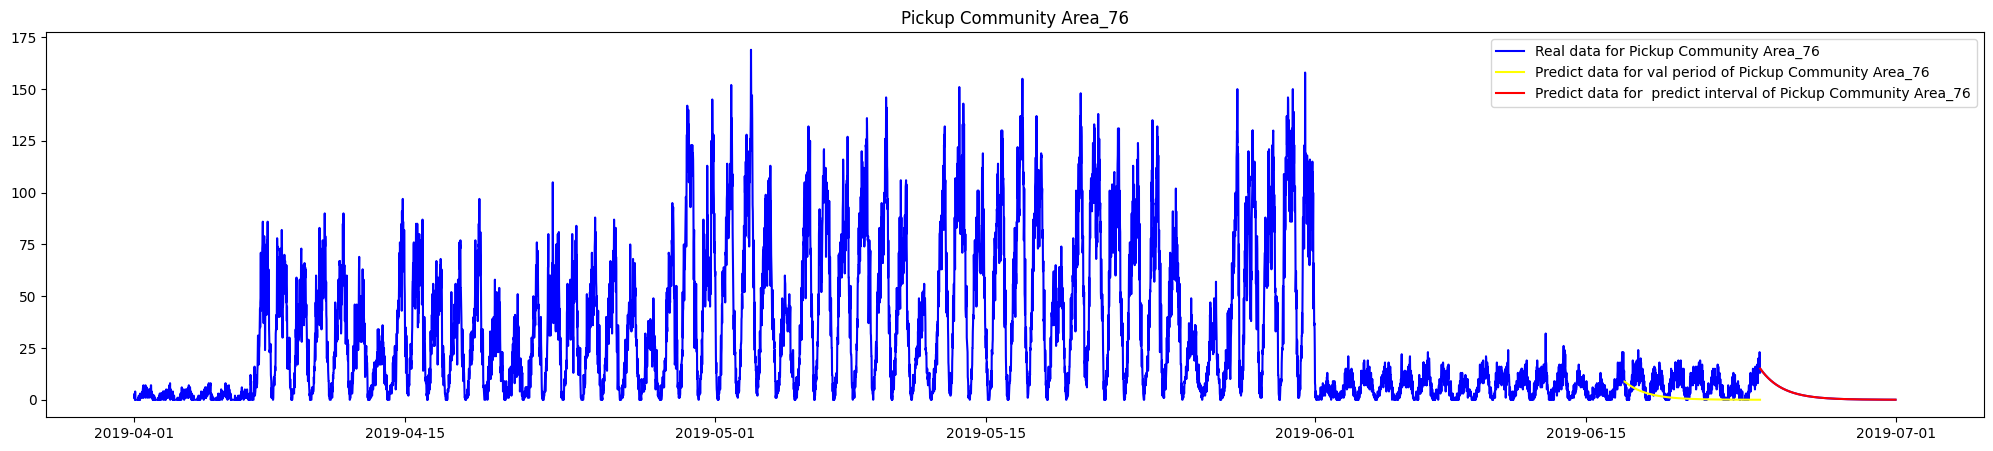

In [92]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_sarimax_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

In [81]:
df_sarimax_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-30 22:45:00,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...
2019-06-30 23:00:00,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...
2019-06-30 23:15:00,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...
2019-06-30 23:30:00,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.statespace.mlemodel.Predictio...,<statsmodels.tsa.stat

In [82]:
tt = df_sarimax_predict.predicted_mean
tt.tail()

AttributeError: 'DataFrame' object has no attribute 'predicted_mean'

In [75]:
df_val_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 22:45:00,-0.000003,7.094598e-08,0.000005,0.000112,0.000693,0.001751,-5.391726e-12,0.000003,0.249324,0.005193,...,6.432549e-08,3.349373e-08,1.168561e-09,1.542586e-07,3.606578e-15,9.933728e-09,0.001658,5.837702e-10,0.018925,0.000069
2019-06-23 23:00:00,-0.000003,6.935768e-08,0.000005,0.000111,0.000688,0.001742,-5.199945e-12,0.000003,0.108093,0.004963,...,6.307346e-08,3.289850e-08,1.141120e-09,1.513577e-07,3.469481e-15,9.727504e-09,0.001657,5.706519e-10,0.018752,0.000068
2019-06-23 23:15:00,-0.000003,6.780495e-08,0.000004,0.000110,0.000682,0.001733,-5.014986e-12,0.000003,0.247556,0.005192,...,6.184580e-08,3.231386e-08,1.114325e-09,1.484231e-07,3.337596e-15,9.525561e-09,0.001657,5.578283e-10,0.018580,0.000068
2019-06-23 23:30:00,-0.000003,6.628697e-08,0.000004,0.000108,0.000677,0.001725,-4.836606e-12,0.000003,0.106394,0.004964,...,6.064203e-08,3.173960e-08,1.088158e-09,1.456314e-07,3.210724e-15,9.327810e-09,0.001657,5.452929e-10,0.018410,0.000067
2019-06-23 23:45:00,-0.000003,6.480298e-08,0.000004,0.000107,0.000672,0.001716,-4.664571e-12,0.000003,0.245804,0.005191,...,5.946170e-08,3.117555e-08,1.062607e-09,1.428084e-07,3.088674e-15,9.134165e-09,0.001657,5.330392e-10,0.018241,0.000066


In [76]:
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

0.8864029361582161

In [ ]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller


def adfuller_test(series, signif=0.05):

	"""
	Perform Augmented Dickey-Fuller to test for Stationarity of the given series
	and print report. Null Hypothesis: Data has unit root and is non-stationary.

	series: time series in pd.Series format
	signif: significance level for P-value to reject Null Hypothesis
	"""
	x = adfuller(series, autolag='AIC')

	#using dictionary saves different data types (float, int, boolean)
	output = {'Test Statistic': x[0],
			  'P-value': x[1],
			  'Number of lags': x[2],
			  'Number of observations': x[3],
			  f'Reject (signif. level {signif})': x[1] < signif }

	for key, val in x[4].items():
		output[f'Critical value {key}'] = val

	return Series(output)


In [ ]:
res = df_train.apply(lambda x: adfuller_test(x, 0.05), axis=0)

In [ ]:
print(res['Pickup Community Area_76'])

In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
%matplotlib inline

series = np.random.randn(100)
result = adfuller(series, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
	print('Critial Values:')
	print(f'   {key}, {value}')

In [ ]:
import statsmodels.api as sm

for area in df_train:
	p = sm.tsa.stattools.adfuller(df_train[area])[1]
	print(f'{area}: Критерий Дики-Фуллера (p-value) = {p}')